In [100]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_theme()
import pickle
from datetime import datetime
import pytz
from pytz import common_timezones
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 100)

In [276]:
df = pd.read_csv('/Users/Mike/Flatiron_020121/king_county_phase2_project/king_county_property_values_analysis_predictive_model/data/kc_house_data_train.csv', index_col='Unnamed: 0')
print(df.shape)
df.head()

(17290, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


# Initial EDA

I first explore the data to see how large the dataset is, what features I have to work with, and check for null values. This dataset fortunately does not have any null values, but that doesn't mean that no cleaning is necessary. For values that appear to be outliers or simply incorrect, I will evaluate case-by-case and impute values depending on the context.  
  
  As the CRISP-DM process involves consistantly reevaluating data, the full EDA will involve thorough analysis of each feature of the dataset.

- 17290 rows of items
- 22 columns
  - 22 columns originally
  - Former column **'Unnamed: 0'** imported as index column
  - added **years_old**
- 0 null items

The features of the dataset are the following:
- id
- date
- **price**
- bedrooms
- bathrooms
- sqft_living
- sqft_lot
- floors
- waterfront
- view
- condition
- grade
- sqft_above
- sqft_basement
- yr_built
- yr_renovated
- zipcode
- lat 
- long
- sqft_living15
- sqft_lot15

In [277]:
df.price.isna().sum() # checking for null values in target

0

### Checking Datatypes
The datatype for 'date' gets converted to datetime64[ns] in the cleaning process to be more manageable in creating features related to the date of sale, and to simply make referencing sale date easier.

In [278]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

# Cleaning, Feature Engineering, and Creating Dummy Variables

In [279]:
# CLEANING: formatting date column from ICS datetime to datetime64(ns) for easier manipulation with Pandas
df.date = pd.to_datetime(df['date'], format='%Y/%m/%d') 

# creates variable representing today with format matching the cleaned 'date' column formatting
today = pd.to_datetime(pd.Timestamp.today(), format='%Y/%m/%d') 

# FE: number representing how many years ago (from today) that the sale occurred
df['yrs_since_sale'] = pd.to_numeric((today-df.date)/(3.154*10**16)) 

# FE: number representing age of property in years
df['yrs_old'] = 2021-df.yr_built 

# FE: how many years since renovation
df['yrs_since_renovation'] = 2021-df.yr_renovated 

# CLEANING: corrects properties that have never been renovated for engineered feature 'yrs_since_renovation'
df['yrs_since_renovation'] = np.where(df.yrs_since_renovation == 2021, 
                                      df.yrs_old, 
                                      df.yrs_since_renovation)

# FE: how many years since renovation at year of sale, create from 'yrs_since_renovation' minus 'yrs_since_sale'
df['yrs_since_ren_at_sale'] = (df.yrs_since_renovation - df.yrs_since_sale) 

# FE: subtracts total property livable sq. ft. divided by number of floors from lot size to estimate yard size 
df['sqft_yard'] = (df.sqft_lot-(df.sqft_living/df.floors)) 

# CLEANING: sets negative yard values to 0
df['sqft_yard'] = np.where(df.sqft_yard < 0, 
                                      0, 
                                      df.sqft_yard)

# CLEANING: sets 33 bedrooms to 3 (median and likely intended entry)
df['bedrooms'] = np.where(df.bedrooms == 33, 
                                      3, 
                                      df.bedrooms)

# CLEANING: caps total number of bedrooms to IQR max
df['bedrooms'] =  np.where(df['bedrooms'] >8, 
                                      8, 
                                      df.bedrooms)

# CLEANING: drops properties with 0 bedrooms
df['bedrooms'] =  np.where(df['bedrooms'] < 1, 
                                      1, 
                                      df.bedrooms)

# CLEANING: caps total number of bathrooms where number of bathrooms > 4 to IQR max
df['bathrooms'] =  np.where(df.bathrooms >4, 
                                      4, 
                                      df.bathrooms)

# CLEANING: caps properties total number of bathrooms where number of bathrooms < .75 to .75 bathrooms
df['bathrooms'] =  np.where(df.bathrooms <.75, 
                                      .75, 
                                      df.bathrooms)

# FE: creates a dummy variable similar to 'waterfront', that marks a property does not have 0 listed for the sqft of their basement 
df['sqft_basement_not_zero'] = np.where(df.sqft_basement == 0,
                                       1,
                                       0)

# CLEANING: caps properties with grades < 5 to grade 5
df['grade'] = np.where(df.grade < 5,
                       5,
                       df.grade)

# CLEANING: caps properties with grades > 11 to 11
df['grade'] = np.where(df.grade > 11, 
                       11, 
                       df.grade)

# FE: creates feature 'price_per_sqft_living' from 'price and 'sqft_living' (for data analysis, not to be used in final model)
df['price_per_sqft_living'] = (df['price']/df['sqft_living'])

# DUMMY: creates dummy variable for rural or not
df['rural'] = np.where(df.long > -121.961527, 
                                      1, 
                                      0)

# DUMMY: creates dummy variable for if property is within Seattle city limits or not
df['within_seattle_city_limits'] = np.where((df.long < -122.251569)
                                            & (df.long > -122.438230)
                                            & (df.lat < 47.734178)
                                            & (df.lat > 47.495479),
                                            1, 
                                            0)  

# FE: creates 'sale_month' from 'date' column's datetime64 type data
df['sale_month'] = df.date.dt.month # isolating sale month from 'date' column datetime64 object

# FE: creates 'sale_year' from 'date' column's datetime64 type data
df['sale_year'] = df.date.dt.year 

# DUMMY: dummy variable columns for each season
df['sale_season_winter'] = np.where(((df.sale_month == 1)
                                   | (df.sale_month == 2)
                                   | (df.sale_month == 3)),
                                   1,
                                   0)

df['sale_season_spring'] = np.where(((df.sale_month == 4)
                            | (df.sale_month == 5)
                            | (df.sale_month == 6)),
                             1,
                             0)

df['sale_season_summer'] = np.where(((df.sale_month == 7)
                                   | (df.sale_month == 8)
                                   | (df.sale_month == 9)),
                                   1,
                                   0)

df['sale_season_fall'] = np.where(((df.sale_month == 10)
                                 | (df.sale_month == 11)
                                 | (df.sale_month == 12)),
                                  1,
                                  0)

# CLEANING: not relevant to analysis nor predictive model
df.drop(columns='id', inplace = True) 

In [281]:
# creating variables for property sales within Seattle, in the suburbs of Seattle, and rural King's County.
rural = df[df.rural == 1]
suburb = df[(df.rural == 0) & (df.within_seattle_city_limits == 0)]
city = df[df.within_seattle_city_limits == 1]

# creating variables for poperty sales by season
winter = df[df.sale_season_winter == 1].price
spring = df[df.sale_season_spring == 1].price
summer = df[df.sale_season_summer == 1].price
fall = df[df.sale_season_fall == 1].price


In [282]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,sqft_basement_not_zero,price_per_sqft_living,rural,within_seattle_city_limits,sale_month,sale_year,sale_season_winter,sale_season_spring,sale_season_summer,sale_season_fall
0,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,6,35,35,29,7858.0,1,176.328502,0,0,10,2014,0,0,0,1
1,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,6,44,44,38,3830.0,0,298.275862,0,1,8,2014,0,0,1,0
2,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,6,24,24,18,9008.0,1,275.331565,0,0,8,2014,0,0,1,0
3,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,3,11,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,5,31,31,26,12328.0,1,326.754386,0,0,3,2015,1,0,0,0
4,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,6,17,17,11,4101.0,1,278.823529,0,0,7,2014,0,0,1,0


### Correlation Matrix & Heatmap

Using a correlation matrix and heatmap is useful for two reasons primarily:
 - to see how predictor features relate to the target variable, to get a sense of what may be impacting the target the most
 - to see how predictors relate to each other, which gives a sense of where predictors may *not* be impacting the target as much as they seem, and simply are heavily correlated with another predictor that is more responsible for the target's value.  
  
  In the latter case, we will need to run our predictive model in instances without one predictor that is related with another, in order to avoid multicolinearity, which would give us an inaccurate model that appears to be good.

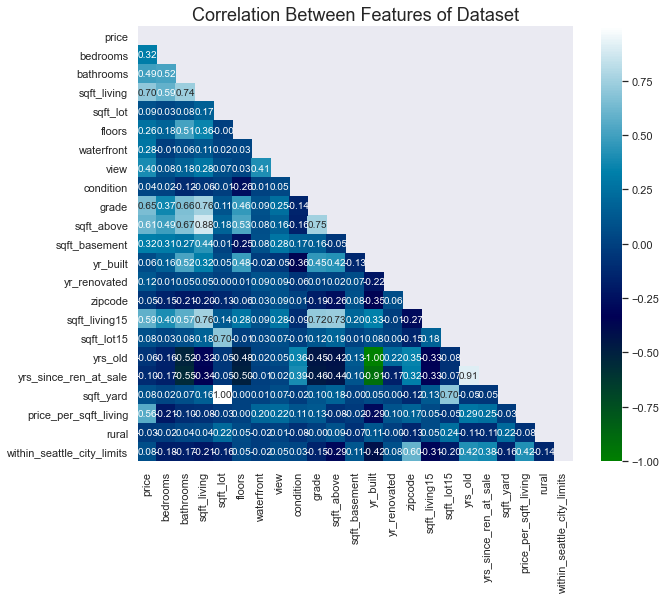

In [99]:
# Creating a correlation matrix
corr_matrix = df.corr()

# Trimming the fat
df_slim = df.drop(columns=['sale_season_fall', 'sale_season_summer', 'sale_season_winter', 'sale_season_spring', 'sale_year', 'sale_month', 'yrs_since_sale', 'yrs_since_renovation', 'lat', 'long'])
corr_matrix_slim = df_slim.corr()

# Creating a mask to restrict heatmap to half, improve readability by not repeating correlation values
mask = np.triu(np.ones_like(corr_matrix_slim, dtype=bool))

# Plotting correlation matrix as seaborn heatmap
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Correlation Between Features of Dataset', size=18)

sns.heatmap(corr_matrix_slim, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap='ocean', );

Predictors correlated with our target **price**:
- **sqft_living**
- **grade**
- sqft_living15
- Bathrooms
- sqft_above

Predictors correlated with each other:  
- Grade and sqft_living are highly correlated with each other (.7)
  - careful with multicolinearity with these two
  - this also goes for sqft_living15 for both
  - this also goes for bathrooms for both

In [90]:
df.grade.value_counts()

7     7183
8     4848
9     2099
6     1648
10     893
11     319
5      192
12      72
4       22
13      11
3        2
1        1
Name: grade, dtype: int64

In [92]:
df[df.grade == 3]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living,rural,within_seattle_city_limits,sale_month,sale_year,sale_season_winter,sale_season_spring,sale_season_summer,sale_season_fall
5489,2015-02-25,262000.0,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233,6,101,101,95,12461.0,503.846154,0,0,2,2015,1,0,0,0
9060,2015-02-17,75000.0,1,0.75,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882,6,55,55,49,42707.0,111.940299,1,0,2,2015,1,0,0,0


In [ ]:
np.where(df.grade < 5,
        5,
        df.grade)

np.where(df.grade > 11,
        11,
        df.grade)

# Feature Engineering
- yrs_since_sale **ADDED**
- years_old **ADDED**
- yrs_since_renovation **ADDED**
- yrs_since_ren_at_sale **ADDED**
- sqft_yard **ADDED**
- price_per_sqft_living **ADDED** **Note: Not for use in model**
- sale_year **ADDED**
- sale_month **ADDED**
- sale_season
  - **ADDED** as dummy variable columns:
    - **sale_season_winter** 
    - **sale_season_spring** 
    - **sale_season_summer** 
    - **sale_season_fall**
  - Spring is hottest market for real estate
  - **do as dummy variable categories**
    - winter = Jan-Feb-March
    - spring = Apr-May-Jun
    - summer = July-Aug-Sept
    - fall = Oct-Nov-Dec
- Geofencing
  - rural dummy variable **ADDED**
  - within_seattle_city_limits dummy variable **ADDED**
  - Seattle City Limits Fence LAT|LONG:
    - NE Corner:
      - 47.734178 -122.251569
    - SE Corner:
      - 47.495479 -122.251569
    - SW Corner:
      - 47.495479 -122.438230
    - NW Corner:
      - 47.734178 -122.438230
  - Rural Fence:
    - North Fence Post:
      - 47.777204 -121.961527
    - South Fence Post:
      - 47.078583 -121.961527
- <u>**Further feature engineering to consider:</u>**
  - - inflation adjuster
    - note: not necessary on holdout dataset is from same years, but would be great in building a predictive model for future data with sale dates from other years.
    - would be a cool, if not necessary, engineered feature for a bigger project.
  - more Geofencing that could be useful:
    - pinpoint locations that are near certain locations. Such as:
    - schools
    - universities
    - parks
    - beaches
    - lakes
    - general waterfront, if 'waterfront' column proves to be too dirty
    - museums
    - highways (or other nuisant noise polluters)
    - methadone clinics
    - homeless shelters
    - within city limits or more rural (appears to be divided by north-to-south routes 203-202-18-169-410) 
    - islands vs mainland
      - Vashon Island
      - Mercer Island
      - Maury Island
    - major employers
      - The Boeing Co. (71,829 employed statewide)
      - Amazon.com (60,000)
      - Microsoft Corp. (55,063)
      - Joint Base Lewis-McChord (54,000)
      - University of Washington Seattle (46,824)
      - source https://www.bizjournals.com/seattle/subscriber-only/2020/06/19/largest-employers.html

### city / suburban / rural

Conditional variable that uses **within_seattle_city_limits** and **rural** engineered dummy variable features to separate rural, suburban, and city properties. 

In [47]:
rural = df[df.rural == 1]
suburb = df[(df.rural == 0) & (df.within_seattle_city_limits == 0)]
city = df[df.within_seattle_city_limits == 1]

# Hypotheses and Statistical Tests

In [48]:
df.price.mean()

540739.5486408329

#### The average property sale price of a property in King County is \$540,900.  
We will take a look at the following with statistical tests:  
1. whether waterfront properties have a different sale price on average than those without. 
  - Method: two sample, paired t-test
2. whether or not there is a difference between the mean property sale price for properties that are within Seattle city limits, in the suburbs of Seattle, and further out in the rural parts of King County.
  - Method: ANOVA f-test with 3 samples.
3. whether or not there is a difference between the mean property sale price between different zipcodes.
  - Method: ANOVA f-test with 70 samples.
4. whether or not the season that a property sale occurred has a statistically significant impact on sale price.
  - Method: ANOVA f-test with 4 samples.
5. whether or not the year that the property was built has an impact on its sale price.
  - Method: ANOVA f-test with 116 samples.  

## 1. 
 - $H_0$: The mean sale price of waterfront properties is not different from the mean price of non-waterfront properties.
 - $H_a$: The mean sale price of waterfront properties is different from the mean price of non-waterfront properties.

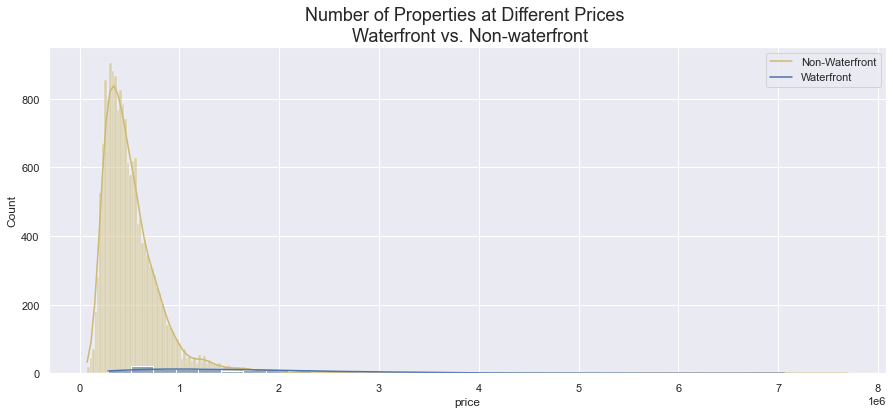

In [49]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Number of Properties at Different Prices \n Waterfront vs. Non-waterfront', size = 18)

sns.histplot(data=df, x=df[df.waterfront == 0].price, 
             color = 'y', label = 'Non-Waterfront', kde=True, ax = ax)
sns.histplot(data=df, x=df[df.waterfront == 1].price, 
             color = 'b', label = 'Waterfront', bins = 30, kde=True, ax = ax)
ax.legend(labels=['Non-Waterfront', 'Waterfront']);

- It's difficult to takeaway much about how the distribution of waterfront property sales per sale price.
- We can get a better view of a distribution comparison using by plotting the density of properties per sale price.

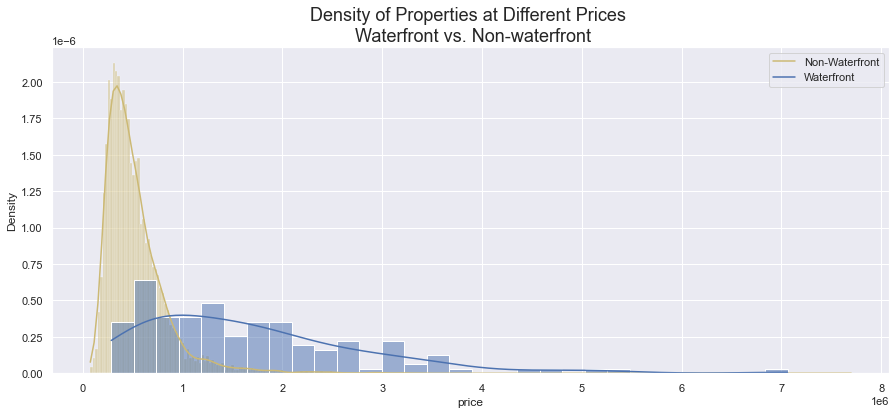

In [21]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Density of Properties at Different Prices \n Waterfront vs. Non-waterfront', size = 18)

sns.histplot(data=df, x=df[df.waterfront == 0].price, 
             color = 'y', label = 'Non-Waterfront', kde=True, stat='density', ax = ax)
sns.histplot(data=df, x=df[df.waterfront == 1].price, 
             color = 'b', label = 'Waterfront', bins = 30, kde=True, stat='density', ax = ax)
ax.legend(labels=['Non-Waterfront', 'Waterfront']);

In [907]:
a = df[df.waterfront == 1].price
b = df[df.waterfront == 0].price

stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='omit')

Ttest_indResult(statistic=37.71740313594821, pvalue=3.10797062240795e-299)

### Conclusion:  
The t-test outcome has a p-value close to 0. I reject the null hypothesis that the mean sale price of waterfront properties is not different from the mean price of non-waterfront properties.

Though only 138 properties in our dataset represent waterfront, it will be worthy of distinguishing these properties in our model, though we must run a correlation matrix again at the beginning stage of building our model, and be vigilant against multicolinearity.

In [1024]:
len(df[df.waterfront == 1])

138

<br><br><br>

## 2.  
 - $H_0$: The mean sale price of properties within city limits of Seattle, suburban King County, and rural King County are not different.  
 - $H_a$: $H_0$ is not true.

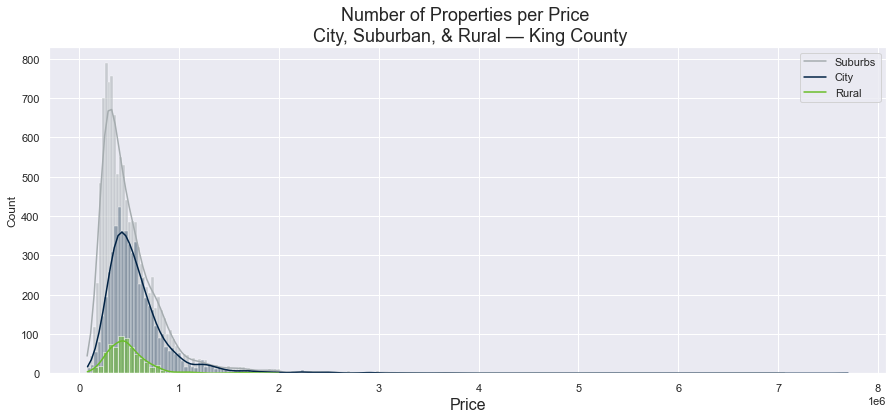

In [42]:
rural = df[df.rural == 1]
suburb = df[(df.rural == 0) & (df.within_seattle_city_limits == 0)]
city = df[df.within_seattle_city_limits == 1]

fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Price', size=16)
ax.set_title('Number of Properties per Price \n City, Suburban, & Rural — King County', size=18)

sns.histplot(suburb['price'], kde = True, color = '#A5ACAF')
sns.histplot(city['price'], kde = True, color = '#002244', alpha=.3)
sns.histplot(rural['price'], kde = True, color = '#69BE28')
ax.legend(labels=['Suburbs', 'City', 'Rural'])
plt.savefig('/Users/Mike/Flatiron_020121/king_county_phase2_project/king_county_property_values_analysis_predictive_model/images/city_sub_rural.png');

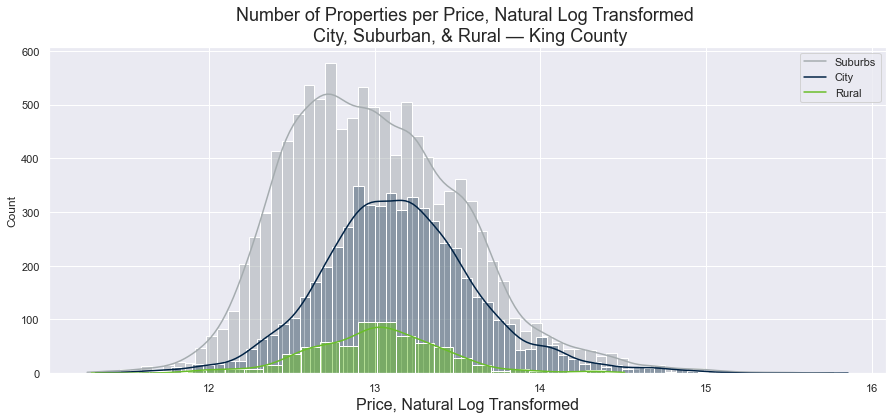

In [40]:
rural = df[df.rural == 1]
suburb = df[(df.rural == 0) & (df.within_seattle_city_limits == 0)]
city = df[df.within_seattle_city_limits == 1]

fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Price, Natural Log Transformed', size=16)
ax.set_title('Number of Properties per Price, Natural Log Transformed \n City, Suburban, & Rural — King County', size=18)

sns.histplot(np.log(suburb['price']), kde = True, color = '#A5ACAF')
sns.histplot(np.log(city['price']), kde = True, color = '#002244', alpha=.3)
sns.histplot(np.log(rural['price']), kde = True, color = '#69BE28')
ax.legend(labels=['Suburbs', 'City', 'Rural'])
plt.savefig('/Users/Mike/Flatiron_020121/king_county_phase2_project/king_county_property_values_analysis_predictive_model/images/ALPHA_city_sub_rural_LOG.png', transparent=True);

- Let's view again by density to get a better sense of comparision between distributions between these three.

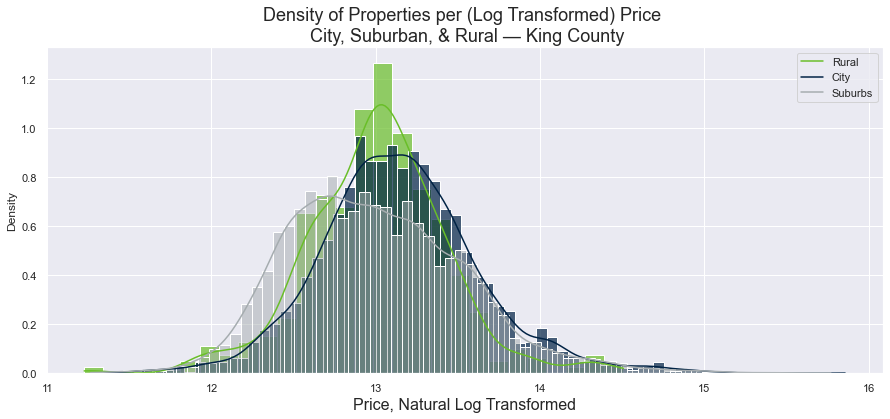

In [20]:
rural = df[df.rural == 1]
suburb = df[(df.rural == 0) & (df.within_seattle_city_limits == 0)]
city = df[df.within_seattle_city_limits == 1]

fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Price, Natural Log Transformed', size=16)
ax.set_title('Density of Properties per (Log Transformed) Price \n City, Suburban, & Rural — King County', size=18)

sns.histplot(np.log(rural['price']), kde = True, color = '#69BE28', alpha=.7, stat='density')
sns.histplot(np.log(city['price']), kde = True, color = '#002244', alpha=.7, stat='density')
sns.histplot(np.log(suburb['price']), kde = True, color = '#A5ACAF', stat='density')

ax.legend(labels=['Rural', 'City', 'Suburbs'])
plt.savefig('/Users/Mike/Flatiron_020121/king_county_phase2_project/king_county_property_values_analysis_predictive_model/images/city_sub_rural.png');

In [1022]:
stats.f_oneway(rural['price'], suburb['price'], city['price'])

F_onewayResult(statistic=54.32021156599743, pvalue=3.040352990681827e-24)

In [54]:
print('Median Sale Prices:') 
print(f'Rural: {rural.price.median()}')
print(f'Suburbs: {suburb.price.median()}')
print(f'City: {city.price.median()}')

Median Sale Prices:
Rural: 450000.0
Suburbs: 425000.0
City: 500000.0


### Conclusion:  
The ANOVA test outcome has a p-value close to 0. I reject the null hypothesis that the mean price of properties within city limits of Seattle, suburban King County, and rural King County are not different.  
  
We should certainly consider this category worthy of distinction when we build our predictive model.

<br><br><br>

## 3. 
 - $H_0$: The mean sale price of sample properties in different zipcodes are not different.  
 - $H_a$: $H_0$ is not true.

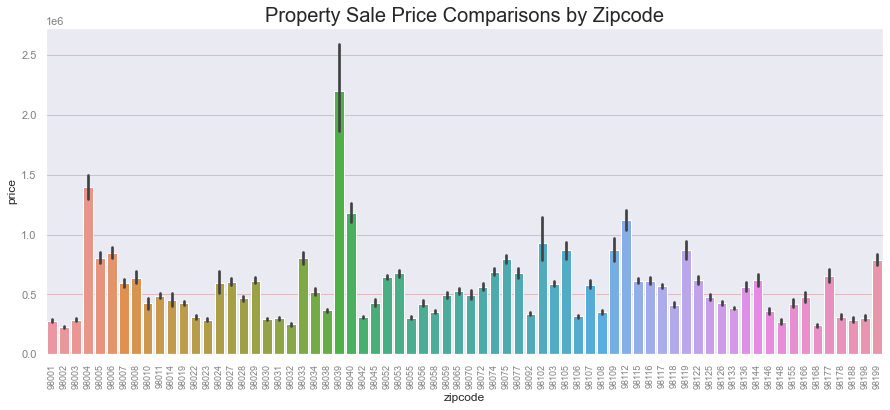

In [1123]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Sale Price Comparisons by Zipcode', size = 20)
ax.tick_params(direction='out', length=6, width=1.5, colors='grey',
               grid_color='r', grid_alpha=0.3)
plt.xticks(rotation=90, size=9)
sns.barplot(x='zipcode', y='price', data=df);

In [1066]:
# here we are creating a sequence that allows us to copy and paste the many categorical variables directly in to our ANOVA test
zipcodes = []
for zipcode in df.zipcode.unique():
    zipcodes.append('df[df.zipcode == '+str(zipcode)+'].price')
zips = f'{zipcodes}'
cleaned_zips = zips.replace('\'', '')
cleaned_zips # beautiful bricks. Copy and paste output in to ANOVA test function.

'[df[df.zipcode == 98058].price, df[df.zipcode == 98115].price, df[df.zipcode == 98006].price, df[df.zipcode == 98034].price, df[df.zipcode == 98052].price, df[df.zipcode == 98031].price, df[df.zipcode == 98007].price, df[df.zipcode == 98199].price, df[df.zipcode == 98027].price, df[df.zipcode == 98119].price, df[df.zipcode == 98122].price, df[df.zipcode == 98155].price, df[df.zipcode == 98055].price, df[df.zipcode == 98118].price, df[df.zipcode == 98014].price, df[df.zipcode == 98059].price, df[df.zipcode == 98004].price, df[df.zipcode == 98053].price, df[df.zipcode == 98072].price, df[df.zipcode == 98133].price, df[df.zipcode == 98092].price, df[df.zipcode == 98074].price, df[df.zipcode == 98125].price, df[df.zipcode == 98045].price, df[df.zipcode == 98106].price, df[df.zipcode == 98022].price, df[df.zipcode == 98177].price, df[df.zipcode == 98008].price, df[df.zipcode == 98002].price, df[df.zipcode == 98040].price, df[df.zipcode == 98029].price, df[df.zipcode == 98042].price, df[df.

In [1067]:
stats.f_oneway(df[df.zipcode == 98058].price, df[df.zipcode == 98115].price, df[df.zipcode == 98006].price, df[df.zipcode == 98034].price, df[df.zipcode == 98052].price, df[df.zipcode == 98031].price, df[df.zipcode == 98007].price, df[df.zipcode == 98199].price, df[df.zipcode == 98027].price, df[df.zipcode == 98119].price, df[df.zipcode == 98122].price, df[df.zipcode == 98155].price, df[df.zipcode == 98055].price, df[df.zipcode == 98118].price, df[df.zipcode == 98014].price, df[df.zipcode == 98059].price, df[df.zipcode == 98004].price, df[df.zipcode == 98053].price, df[df.zipcode == 98072].price, df[df.zipcode == 98133].price, df[df.zipcode == 98092].price, df[df.zipcode == 98074].price, df[df.zipcode == 98125].price, df[df.zipcode == 98045].price, df[df.zipcode == 98106].price, df[df.zipcode == 98022].price, df[df.zipcode == 98177].price, df[df.zipcode == 98008].price, df[df.zipcode == 98002].price, df[df.zipcode == 98040].price, df[df.zipcode == 98029].price, df[df.zipcode == 98042].price, df[df.zipcode == 98001].price, df[df.zipcode == 98065].price, df[df.zipcode == 98056].price, df[df.zipcode == 98144].price, df[df.zipcode == 98188].price, df[df.zipcode == 98109].price, df[df.zipcode == 98010].price, df[df.zipcode == 98075].price, df[df.zipcode == 98198].price, df[df.zipcode == 98030].price, df[df.zipcode == 98105].price, df[df.zipcode == 98023].price, df[df.zipcode == 98028].price, df[df.zipcode == 98112].price, df[df.zipcode == 98038].price, df[df.zipcode == 98116].price, df[df.zipcode == 98103].price, df[df.zipcode == 98178].price, df[df.zipcode == 98168].price, df[df.zipcode == 98005].price, df[df.zipcode == 98077].price, df[df.zipcode == 98146].price, df[df.zipcode == 98011].price, df[df.zipcode == 98126].price, df[df.zipcode == 98108].price, df[df.zipcode == 98136].price, df[df.zipcode == 98033].price, df[df.zipcode == 98003].price, df[df.zipcode == 98117].price, df[df.zipcode == 98107].price, df[df.zipcode == 98019].price, df[df.zipcode == 98102].price, df[df.zipcode == 98032].price, df[df.zipcode == 98148].price, df[df.zipcode == 98166].price, df[df.zipcode == 98070].price, df[df.zipcode == 98024].price, df[df.zipcode == 98039].price)

F_onewayResult(statistic=167.16755274302105, pvalue=0.0)

### Conclusion:  
  We reject the null hypothesis that there are no differences in the mean sale price of sample properties in different zipcodes.  
  
  There appear to be significant disparities between home prices based on zipcode. This must be accounted for in the model!  
  
  It's important to note that knowing that there is a difference in mean sale price between *any of the zipcodes* may not be as useful as were I to use fewer samples, eg. grouping zipcodes where mean sale prices where closer to the median of all property sales, grouping others in to higher or lower mean sale price groups, and handling that individual extreme-high mean sale price outlier zipcode as its own group. 
  
  As the zipcodes may be considered categorical features, we will create dummy variables to manage them in the model. We can try both methods of dummying by all zipcodes, and dummying by zipcode groupings, as we go through the model selection process.

## 4. 
 - $H_0$: The mean sale price of properties sold in different seasons is not different during different seasons.  
 - $H_a$: $H_0$ is not true.

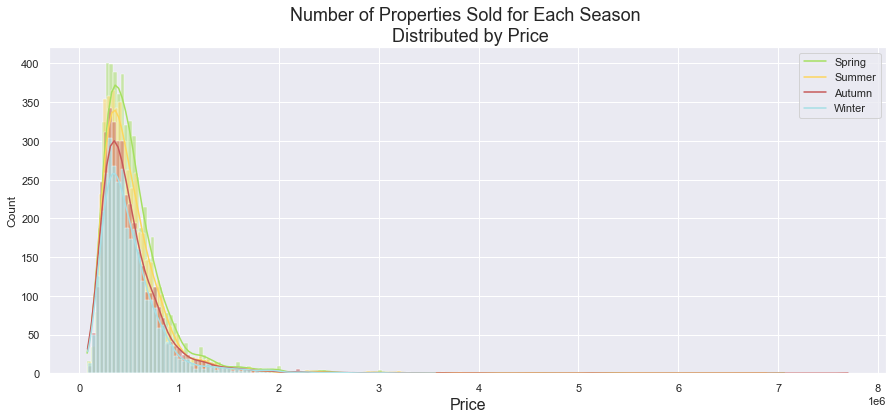

In [38]:
winter = df[df.sale_season_winter == 1].price
spring = df[df.sale_season_spring == 1].price
summer = df[df.sale_season_summer == 1].price
fall = df[df.sale_season_fall == 1].price

fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Price', size=16)
ax.set_title('Number of Properties Sold for Each Season \n Distributed by Price', size=18)

sns.histplot(spring, kde = True, color = '#a5e060')
sns.histplot(summer, kde = True, color = '#fdd65d')
sns.histplot(fall, kde = True, color = '#c75959', alpha= .5)
sns.histplot(winter, kde = True, color = '#a5dfe6', alpha= .7)
ax.legend(labels=['Spring', 'Summer', 'Autumn', 'Winter'])
# plt.savefig('/Users/Mike/Flatiron_020121/king_county_phase2_project/king_county_property_values_analysis_predictive_model/images/Seasons.png');

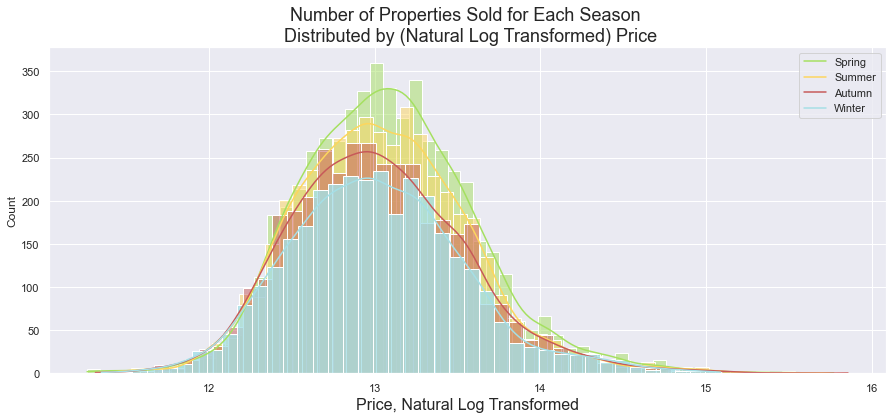

In [36]:
winter = df[df.sale_season_winter == 1].price
spring = df[df.sale_season_spring == 1].price
summer = df[df.sale_season_summer == 1].price
fall = df[df.sale_season_fall == 1].price

fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Price, Natural Log Transformed', size=16)
ax.set_title('Number of Properties Sold for Each Season \n Distributed by (Natural Log Transformed) Price', size=18)

sns.histplot(np.log(spring), kde = True, color = '#a5e060')
sns.histplot(np.log(summer), kde = True, color = '#fdd65d')
sns.histplot(np.log(fall), kde = True, color = '#c75959', alpha = .5)
sns.histplot(np.log(winter), kde = True, color = '#a5dfe6', alpha = .8)
ax.legend(labels=['Spring', 'Summer', 'Autumn', 'Winter'])
plt.savefig('/Users/Mike/Flatiron_020121/king_county_phase2_project/king_county_property_values_analysis_predictive_model/images/ALPHA_Seasons_LOG.png', transparent=True);

- Again, by density to get a better sense of comparision between distributions between these three.

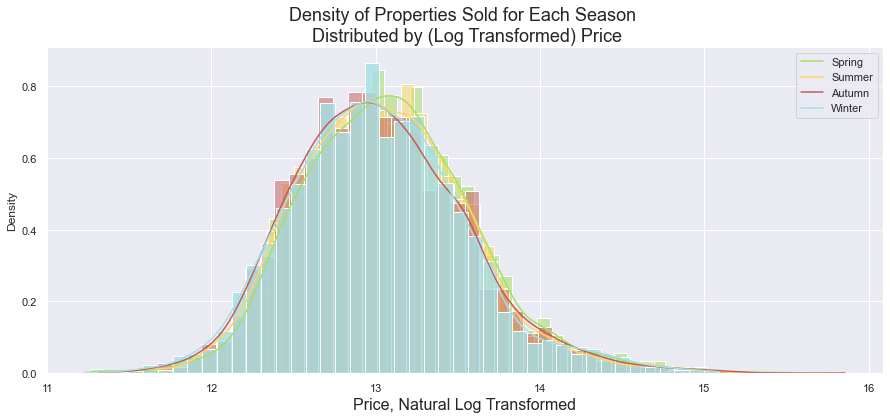

In [23]:
winter = df[df.sale_season_winter == 1].price
spring = df[df.sale_season_spring == 1].price
summer = df[df.sale_season_summer == 1].price
fall = df[df.sale_season_fall == 1].price

fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Price, Natural Log Transformed', size=16)
ax.set_title('Density of Properties Sold for Each Season \n Distributed by (Log Transformed) Price', size=18)

sns.histplot(np.log(spring), kde = True, color = '#a5e060', stat='density')
sns.histplot(np.log(summer), kde = True, color = '#fdd65d', stat='density')
sns.histplot(np.log(fall), kde = True, color = '#c75959', alpha = .5, stat='density')
sns.histplot(np.log(winter), kde = True, color = '#a5dfe6', alpha = .8, stat='density')
ax.legend(labels=['Spring', 'Summer', 'Autumn', 'Winter'])
plt.savefig('/Users/Mike/Flatiron_020121/king_county_phase2_project/king_county_property_values_analysis_predictive_model/images/ALPHA_Seasons_LOG.png', transparent=True);

In [1106]:
stats.f_oneway(winter, spring, summer, fall)

F_onewayResult(statistic=7.019439879954201, pvalue=0.00010298073038170776)

### Conclusion:  
  We reject the null hypothesis that there is no differences in the mean sale price of properties sold in different seasons.
  
  As season may be considered categorical a feature, we will create dummy variables to manage them in the model.

<br><br><br>

## 5. 
 - $H_0$: The mean price of properties built in different years is not different.  
 - $H_a$: $H_0$ is not true.  

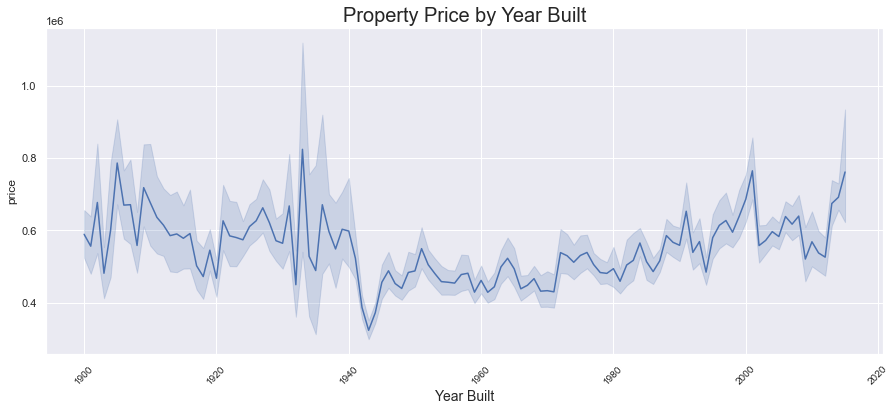

In [1141]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Price by Year Built', size=20)
ax.set_xlabel('Year Built', size=14)
plt.xticks(rotation=45, size=10)
sns.lineplot(data=df, x=df.yr_built, y=df.price, ax=ax)
plt.savefig('/Users/Mike/Flatiron_020121/king_county_phase2_project/king_county_property_values_analysis_predictive_model/images/ALPHA_price_by_year_built.png', transparent=True);

In [1069]:
# here we are creating a sequence that allows us to copy and paste the many categorical variables directly in to our ANOVA test
build_years = []
for year in df.yr_built.unique(): 
    build_years.append('df[df.yr_built == '+str(year)+'].price') 
build_yrs = f'{build_years}'
cleaned_build_yrs = build_yrs.replace('\'', '')
cleaned_build_yrs # beautiful bricks. Copy and paste output in to ANOVA test function.

'[df[df.yr_built == 1986].price, df[df.yr_built == 1977].price, df[df.yr_built == 1997].price, df[df.yr_built == 1990].price, df[df.yr_built == 2004].price, df[df.yr_built == 1970].price, df[df.yr_built == 1987].price, df[df.yr_built == 2005].price, df[df.yr_built == 1909].price, df[df.yr_built == 1930].price, df[df.yr_built == 1963].price, df[df.yr_built == 1968].price, df[df.yr_built == 2003].price, df[df.yr_built == 1910].price, df[df.yr_built == 2001].price, df[df.yr_built == 1954].price, df[df.yr_built == 1993].price, df[df.yr_built == 1969].price, df[df.yr_built == 1976].price, df[df.yr_built == 2007].price, df[df.yr_built == 1983].price, df[df.yr_built == 1955].price, df[df.yr_built == 1981].price, df[df.yr_built == 1972].price, df[df.yr_built == 1904].price, df[df.yr_built == 1942].price, df[df.yr_built == 1973].price, df[df.yr_built == 1918].price, df[df.yr_built == 1961].price, df[df.yr_built == 1962].price, df[df.yr_built == 2000].price, df[df.yr_built == 2013].price, df[df.

In [1070]:
stats.f_oneway(df[df.yr_built == 1986].price, df[df.yr_built == 1977].price, df[df.yr_built == 1997].price, df[df.yr_built == 1990].price, df[df.yr_built == 2004].price, df[df.yr_built == 1970].price, df[df.yr_built == 1987].price, df[df.yr_built == 2005].price, df[df.yr_built == 1909].price, df[df.yr_built == 1930].price, df[df.yr_built == 1963].price, df[df.yr_built == 1968].price, df[df.yr_built == 2003].price, df[df.yr_built == 1910].price, df[df.yr_built == 2001].price, df[df.yr_built == 1954].price, df[df.yr_built == 1993].price, df[df.yr_built == 1969].price, df[df.yr_built == 1976].price, df[df.yr_built == 2007].price, df[df.yr_built == 1983].price, df[df.yr_built == 1955].price, df[df.yr_built == 1981].price, df[df.yr_built == 1972].price, df[df.yr_built == 1904].price, df[df.yr_built == 1942].price, df[df.yr_built == 1973].price, df[df.yr_built == 1918].price, df[df.yr_built == 1961].price, df[df.yr_built == 1962].price, df[df.yr_built == 2000].price, df[df.yr_built == 2013].price, df[df.yr_built == 2014].price, df[df.yr_built == 2009].price, df[df.yr_built == 1953].price, df[df.yr_built == 1960].price, df[df.yr_built == 1994].price, df[df.yr_built == 1900].price, df[df.yr_built == 1999].price, df[df.yr_built == 1949].price, df[df.yr_built == 1980].price, df[df.yr_built == 1944].price, df[df.yr_built == 1921].price, df[df.yr_built == 1998].price, df[df.yr_built == 1925].price, df[df.yr_built == 1950].price, df[df.yr_built == 1985].price, df[df.yr_built == 1974].price, df[df.yr_built == 1926].price, df[df.yr_built == 1967].price, df[df.yr_built == 1975].price, df[df.yr_built == 1912].price, df[df.yr_built == 1966].price, df[df.yr_built == 2006].price, df[df.yr_built == 1991].price, df[df.yr_built == 1959].price, df[df.yr_built == 1984].price, df[df.yr_built == 1979].price, df[df.yr_built == 1964].price, df[df.yr_built == 1920].price, df[df.yr_built == 1957].price, df[df.yr_built == 1995].price, df[df.yr_built == 1951].price, df[df.yr_built == 1982].price, df[df.yr_built == 1988].price, df[df.yr_built == 1914].price, df[df.yr_built == 1917].price, df[df.yr_built == 1908].price, df[df.yr_built == 1947].price, df[df.yr_built == 1971].price, df[df.yr_built == 2015].price, df[df.yr_built == 1937].price, df[df.yr_built == 1958].price, df[df.yr_built == 2002].price, df[df.yr_built == 1956].price, df[df.yr_built == 1938].price, df[df.yr_built == 1948].price, df[df.yr_built == 2008].price, df[df.yr_built == 2010].price, df[df.yr_built == 1936].price, df[df.yr_built == 1907].price, df[df.yr_built == 2012].price, df[df.yr_built == 1978].price, df[df.yr_built == 1941].price, df[df.yr_built == 1965].price, df[df.yr_built == 1992].price, df[df.yr_built == 1927].price, df[df.yr_built == 1929].price, df[df.yr_built == 1903].price, df[df.yr_built == 1928].price, df[df.yr_built == 1915].price, df[df.yr_built == 1923].price, df[df.yr_built == 1946].price, df[df.yr_built == 1911].price, df[df.yr_built == 1996].price, df[df.yr_built == 1952].price, df[df.yr_built == 1940].price, df[df.yr_built == 1916].price, df[df.yr_built == 1945].price, df[df.yr_built == 1943].price, df[df.yr_built == 1989].price, df[df.yr_built == 1913].price, df[df.yr_built == 1906].price, df[df.yr_built == 1924].price, df[df.yr_built == 1931].price, df[df.yr_built == 1922].price, df[df.yr_built == 1932].price, df[df.yr_built == 1901].price, df[df.yr_built == 1905].price, df[df.yr_built == 2011].price, df[df.yr_built == 1939].price, df[df.yr_built == 1919].price, df[df.yr_built == 1933].price, df[df.yr_built == 1935].price, df[df.yr_built == 1902].price, df[df.yr_built == 1934].price)

F_onewayResult(statistic=8.150712206577152, pvalue=6.819481574349649e-125)

### Conclusion:  
  We reject the null hypothesis that no difference is present in the mean price of sample properties built in different years.   
  
  Again, it's important to note that knowing that there is a difference in mean sale price between *any years of sale* isn't as informative as were I to use fewer samples, eg. subsecting ranges of sale years in to different groupings. As the build year of properties may be considered categorical features, we will create dummy variables to manage them in the model. We can try both methods of dummying by sale year, and dummying by groups of sale year ranges, as we go through the model selection process.

# Training a Model

1. Clean data √
2. Create features √
3. Fit Model
4. Check Residuals
  - if they're normally distributed
  - for relationship
5. Corrective Measures

- subset in to groups **city**, **suburb**, **rural**
  - subset further by **sale_season_x**
    - subset further in to groups **waterfront**, not waterfront
     - use dummy variables for **grade** (note: watch this one for multicolinearity/independence of errors)
  - see distributions for **price**, **sqft_living**
  - modestly adjust scale by yr_built (or yrs_old, if easier to work with)
  - possibly adjust scale by zipcodes as well... like 98039, Medina, where Bezos and Gates have properties.
- drop other columns **EXCEPT price**
- then **run statistical tests** to see how likely 

In [296]:
df.drop(columns='price_per_sqft_living', inplace=True)

In [442]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yrs_since_sale', 'yrs_old',
       'yrs_since_renovation', 'yrs_since_ren_at_sale', 'sqft_yard',
       'sqft_basement_not_zero', 'rural', 'within_seattle_city_limits',
       'sale_month', 'sale_year', 'sale_season_winter', 'sale_season_spring',
       'sale_season_summer', 'sale_season_fall'],
      dtype='object')

### Polynomial Features

Polynomial features can help us capture some of the unseen relationships between between our features in our model, with the intention of improving the fit.

In [443]:
# training_df = None
# training_df = pd.get_dummies(df, columns=['bedrooms', 'bathrooms', 'grade', 'zipcode'], drop_first=True)

In [444]:
training_df = None
training_df = df.drop(['date', 'yr_built', 'yr_renovated', 'lat', 'long', 'sale_year'], axis=1)

In [445]:
training_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15',
       'yrs_since_sale', 'yrs_old', 'yrs_since_renovation',
       'yrs_since_ren_at_sale', 'sqft_yard', 'sqft_basement_not_zero', 'rural',
       'within_seattle_city_limits', 'sale_month', 'sale_season_winter',
       'sale_season_spring', 'sale_season_summer', 'sale_season_fall'],
      dtype='object')

In [446]:
df_features=training_df.drop(columns='price')

target = df['price']

In [447]:
df_features.isnull().mean().sum() # checking to ensure there are no null values in my features training dataset 

0.0

In [448]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(df_features)
poly_columns = poly.get_feature_names(df_features.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
df_poly.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,sqft_basement_not_zero,rural,within_seattle_city_limits,sale_month,sale_season_winter,sale_season_spring,sale_season_summer,sale_season_fall,bedrooms^2,bedrooms bathrooms,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms waterfront,bedrooms view,bedrooms condition,bedrooms grade,bedrooms sqft_above,bedrooms sqft_basement,bedrooms zipcode,bedrooms sqft_living15,bedrooms sqft_lot15,bedrooms yrs_since_sale,bedrooms yrs_old,bedrooms yrs_since_renovation,bedrooms yrs_since_ren_at_sale,bedrooms sqft_yard,bedrooms sqft_basement_not_zero,bedrooms rural,bedrooms within_seattle_city_limits,bedrooms sale_month,...,yrs_since_ren_at_sale sale_month,yrs_since_ren_at_sale sale_season_winter,yrs_since_ren_at_sale sale_season_spring,yrs_since_ren_at_sale sale_season_summer,yrs_since_ren_at_sale sale_season_fall,sqft_yard^2,sqft_yard sqft_basement_not_zero,sqft_yard rural,sqft_yard within_seattle_city_limits,sqft_yard sale_month,sqft_yard sale_season_winter,sqft_yard sale_season_spring,sqft_yard sale_season_summer,sqft_yard sale_season_fall,sqft_basement_not_zero^2,sqft_basement_not_zero rural,sqft_basement_not_zero within_seattle_city_limits,sqft_basement_not_zero sale_month,sqft_basement_not_zero sale_season_winter,sqft_basement_not_zero sale_season_spring,sqft_basement_not_zero sale_season_summer,sqft_basement_not_zero sale_season_fall,rural^2,rural within_seattle_city_limits,rural sale_month,rural sale_season_winter,rural sale_season_spring,rural sale_season_summer,rural sale_season_fall,within_seattle_city_limits^2,within_seattle_city_limits sale_month,within_seattle_city_limits sale_season_winter,within_seattle_city_limits sale_season_spring,within_seattle_city_limits sale_season_summer,within_seattle_city_limits sale_season_fall,sale_month^2,sale_month sale_season_winter,sale_month sale_season_spring,sale_month sale_season_summer,sale_month sale_season_fall,sale_season_winter^2,sale_season_winter sale_season_spring,sale_season_winter sale_season_summer,sale_season_winter sale_season_fall,sale_season_spring^2,sale_season_spring sale_season_summer,sale_season_spring sale_season_fall,sale_season_summer^2,sale_season_summer sale_season_fall,sale_season_fall^2
0,4.0,2.25,2070.0,8893.0,2.0,0.0,0.0,4.0,8.0,2070.0,0.0,98058.0,2390.0,7700.0,6.0,35.0,35.0,29.0,7858.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,16.0,9.0,8280.0,35572.0,8.0,0.0,0.0,16.0,32.0,8280.0,0.0,392232.0,9560.0,30800.0,24.0,140.0,140.0,116.0,31432.0,4.0,0.0,0.0,40.0,...,290.0,0.0,0.0,0.0,29.0,61748164.0,7858.0,0.0,0.0,78580.0,0.0,0.0,0.0,7858.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5.0,3.00,2900.0,6730.0,1.0,0.0,0.0,5.0,8.0,1830.0,1070.0,98115.0,2370.0,6283.0,6.0,44.0,44.0,38.0,3830.0,0.0,0.0,1.0,8.0,0.0,0.0,1.0,0.0,25.0,15.0,14500.0,33650.0,5.0,0.0,0.0,25.0,40.0,9150.0,5350.0,490575.0,11850.0,31415.0,30.0,220.0,220.0,190.0,19150.0,0.0,0.0,5.0,40.0,...,304.0,0.0,0.0,38.0,0.0,14668900.0,0.0,0.0,3830.0,30640.0,0.0,0.0,3830.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,1.0,0.0,64.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4.0,2.50,3770.0,10893.0,2.0,0.0,2.0,3.0,11.0,3770.0,0.0,98006.0,3710.0,9685.0,6.0,24.0,24.0,18.0,9008.0,1.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,16.0,10.0,15080.0,43572.0,8.0,0.0,8.0,12.0,44.0,15080.0,0.0,392024.0,14840.0,38740.0,24.0,96.0,96.0,72.0,36032.0,4.0,0.0,0.0,32.0,...,144.0,0.0,0.0,18.0,0.0,81144064.0,9008.0,0.0,0.0,72064.0,0.0,0.0,9008.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3.0,3.50,4560.0,14608.0,2.0,0.0,2.0,3.0,11.0,4560.0,0.0,98034.0,4050.0,14226.0,5.0,31.0,31.0,26.0,123

In [449]:
len(df_poly.columns) # yowza

405

In [450]:
X_train, X_test, y_train, y_test = train_test_split(df_poly, target, random_state=9, test_size=0.2)

# instantiating a linear regression object
lm = LinearRegression()

# fitting the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

In [451]:
# using fitted model to predict on test data
y_pred = lm.predict(X_test)

# we can use sklearn's metrics package to evaluate the RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training RMSE: ', int(train_rmse), "vs. Testing RMSE: ", int(test_rmse))

Testing Root Mean Squared Error: 183451.7271893806
Training RMSE:  170552 vs. Testing RMSE:  183451


- Training RMSE:  170552  
- Testing RMSE:  183,451  
  
  That's not so bad! We're under 200k for both testing and training. Let's see if we can remove some of the noise added by too many polynomial features.

# Feature Selection

### Select K-Best

Selecting on k-best is a method for feature selection. We can use the feature selection SelectKBest, f_regression, and mutual_info_regression packages from SciKit-Learn to decide which features of the dataset will be most useful for our model.

In [452]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,sqft_basement_not_zero,rural,within_seattle_city_limits,sale_month,sale_season_winter,sale_season_spring,sale_season_summer,sale_season_fall,bedrooms^2,bedrooms bathrooms,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms waterfront,bedrooms view,bedrooms condition,bedrooms grade,bedrooms sqft_above,bedrooms sqft_basement,bedrooms zipcode,bedrooms sqft_living15,bedrooms sqft_lot15,bedrooms yrs_since_sale,bedrooms yrs_old,bedrooms yrs_since_renovation,bedrooms yrs_since_ren_at_sale,bedrooms sqft_yard,bedrooms sqft_basement_not_zero,bedrooms rural,bedrooms within_seattle_city_limits,bedrooms sale_month,...,yrs_since_ren_at_sale sale_month,yrs_since_ren_at_sale sale_season_winter,yrs_since_ren_at_sale sale_season_spring,yrs_since_ren_at_sale sale_season_summer,yrs_since_ren_at_sale sale_season_fall,sqft_yard^2,sqft_yard sqft_basement_not_zero,sqft_yard rural,sqft_yard within_seattle_city_limits,sqft_yard sale_month,sqft_yard sale_season_winter,sqft_yard sale_season_spring,sqft_yard sale_season_summer,sqft_yard sale_season_fall,sqft_basement_not_zero^2,sqft_basement_not_zero rural,sqft_basement_not_zero within_seattle_city_limits,sqft_basement_not_zero sale_month,sqft_basement_not_zero sale_season_winter,sqft_basement_not_zero sale_season_spring,sqft_basement_not_zero sale_season_summer,sqft_basement_not_zero sale_season_fall,rural^2,rural within_seattle_city_limits,rural sale_month,rural sale_season_winter,rural sale_season_spring,rural sale_season_summer,rural sale_season_fall,within_seattle_city_limits^2,within_seattle_city_limits sale_month,within_seattle_city_limits sale_season_winter,within_seattle_city_limits sale_season_spring,within_seattle_city_limits sale_season_summer,within_seattle_city_limits sale_season_fall,sale_month^2,sale_month sale_season_winter,sale_month sale_season_spring,sale_month sale_season_summer,sale_month sale_season_fall,sale_season_winter^2,sale_season_winter sale_season_spring,sale_season_winter sale_season_summer,sale_season_winter sale_season_fall,sale_season_spring^2,sale_season_spring sale_season_summer,sale_season_spring sale_season_fall,sale_season_summer^2,sale_season_summer sale_season_fall,sale_season_fall^2
7189,4.0,2.25,1930.0,8338.0,1.0,0.0,0.0,3.0,8.0,1930.0,0.0,98125.0,2280.0,7616.0,5.0,53.0,53.0,48.0,6408.000000,1.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,16.0,9.0,7720.0,33352.0,4.0,0.0,0.0,12.0,32.0,7720.0,0.0,392500.0,9120.0,30464.0,20.0,212.0,212.0,192.0,25632.0,4.0,0.0,4.0,12.0,...,144.0,48.0,0.0,0.0,0.0,4.106246e+07,6408.000000,0.0,6408.000000,19224.0,6408.000000,0.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12378,2.0,1.00,1060.0,7700.0,1.0,0.0,0.0,3.0,7.0,820.0,240.0,98055.0,1370.0,8833.0,6.0,40.0,40.0,34.0,6640.000000,0.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0,4.0,2.0,2120.0,15400.0,2.0,0.0,0.0,6.0,14.0,1640.0,480.0,196110.0,2740.0,17666.0,12.0,80.0,80.0,68.0,13280.0,0.0,0.0,0.0,14.0,...,238.0,0.0,0.0,34.0,0.0,4.408960e+07,0.000000,0.0,0.000000,46480.0,0.000000,0.0,6640.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5664,3.0,2.00,1390.0,5127.0,1.0,0.0,0.0,3.0,8.0,1390.0,0.0,98055.0,1960.0,5019.0,6.0,31.0,31.0,25.0,3737.000000,1.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,9.0,6.0,4170.0,15381.0,3.0,0.0,0.0,9.0,24.0,4170.0,0.0,294165.0,5880.0,15057.0,18.0,93.0,93.0,75.0,11211.0,3.0,0.0,0.0,24.0,...,200.0,0.0,0.0,25.0,0.0,1.396517e+07,3737.000000,0.0,0.000000,29896.0,0.000000,0.0,3737.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
927,3.0,1.00,1560.0,3960.0,1.5,0.0,0.0,4.0,7.0,1560

In [453]:
selector = SelectKBest(f_regression, k=200) # k will equal the number of features that we would like to select down to.

selector.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=200, score_func=<function f_regression at 0x7f9c3b846700>)

In [454]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [455]:
list(selected_columns) # these are the lovely features that we're left with

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_basement_not_zero',
 'bedrooms^2',
 'bedrooms bathrooms',
 'bedrooms sqft_living',
 'bedrooms sqft_lot',
 'bedrooms floors',
 'bedrooms waterfront',
 'bedrooms view',
 'bedrooms condition',
 'bedrooms grade',
 'bedrooms sqft_above',
 'bedrooms sqft_basement',
 'bedrooms zipcode',
 'bedrooms sqft_living15',
 'bedrooms sqft_lot15',
 'bedrooms yrs_since_sale',
 'bedrooms sqft_yard',
 'bedrooms within_seattle_city_limits',
 'bedrooms sale_month',
 'bathrooms^2',
 'bathrooms sqft_living',
 'bathrooms sqft_lot',
 'bathrooms floors',
 'bathrooms waterfront',
 'bathrooms view',
 'bathrooms condition',
 'bathrooms grade',
 'bathrooms sqft_above',
 'bathrooms sqft_basement',
 'bathrooms zipcode',
 'bathrooms sqft_living15',
 'bathrooms sqft_lot15',
 'bathrooms yrs_since_sale',
 'bathrooms yrs_old',
 'bathrooms yrs_since_renovation',
 'bathrooms yrs_sin

Now, let's see if we can fit a better model with only the 200 best features.

In [456]:
# instantiating a linear regression object
lm_kbest = LinearRegression()

# fitting the linear regression to the data
lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])

# let's evaluate using sklearn's metrics package again
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))

print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 175115.15859305626
Testing Root Mean Squared Error: 184115.3727858357


- Training Root Mean Squared Error: 175,115  
- Testing Root Mean Squared Error: 184115  
    
    That didn't seem to do much better (if at all), but we're down under 200k RMSE, and our training and testing RMSE are not too far off from each other.
    
    Let's give another feature elimination method ago and see which will provide a better predictive model.

### Recursive Feature Elimination, Cross Validation

RFECV is a popular, flexible method for feature selection. We will use the feature selection RFECV package from SciKit-Learn to decide which features of the dataset will be most useful for our model.

- First we will need to select which features of our dataset we would like to use, and transform/create dummy variables for others if necessary.
- 'price' is my target
- for predictors I will use:  
       'bedrooms', 'bathrooms', 'zipcode', 'grade',
       'sqft_living', 'floors', 'waterfront', 
       'yrs_old', 'yrs_since_ren_at_sale', 'sqft_yard',
       'rural', 'within_seattle_city_limits',
       'sale_month', 'sale_year', 'sale_season_winter', 'sale_season_spring',
       'sale_season_summer', 'sale_season_fall'
- Some dummy variables were created above, but I would also like to create dummy variables for:  
        'zipcode', 'bedrooms', 'bathrooms', and 'grade'
- I will not use:  
        'date', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_lot'
        
- First considerations of other features to drop:  
        'view', 'condition', 'sqft_above', 'sqft_lot',  
        'sqft_basement', 'sqft_living15', 'sqft_lot15',  
        'yrs_since_sale', 'yrs_since_renovation, or price_per_sqft_living.

In [457]:
training_df = None
training_df = pd.get_dummies(df, columns=['bedrooms', 'bathrooms', 'grade', 'zipcode'], drop_first=True)

In [458]:
training_df.head()

,date,price,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,sqft_basement_not_zero,rural,within_seattle_city_limits,sale_month,sale_year,sale_season_winter,sale_season_spring,sale_season_summer,sale_season_fall,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,...,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,2014-10-06,365000.0,2070,8893,2.0,0,0,4,2070,0,1986,0,47.4388,-122.162,2390,7700,6,35,35,29,7858.0,1,0,0,10,2014,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-08-21,865000.0,2900,6730,1.0,0,0,5,1830,1070,1977,0,47.6784,-122.285,2370,6283,6,44,44,38,3830.0,0,0,1,8,2014,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-08-15,1038000.0,3770,10893,2.0,0,2,3,3770,0,1997,0,47.5646,-122.129,3710,9685,6,24,24,18,9008.0,1,0,0,8,2014,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-03-31,1490000.0,4560,14608,2.0,0,2,3,4560,0,1990,0,47.6995,-122.228,4050,14226,5,31,31,26,12328.0,1,0,0,3,2015,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-07-14,711000.0,2550,5376,2.0,0,0,3,2550,0,2004,0,47.6647,-122.083,2250,4050,6,17,17,11,4101.0,1,0,0,7,2014,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [459]:
training_df.drop(['date', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_lot'], axis=1, inplace=True)

In [460]:
training_df.columns

Index(['price', 'sqft_living', 'floors', 'waterfront', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=119)

In [461]:
df_features=training_df.drop(columns='price')

target = df['price']

In [462]:
df_features.isna().mean().sum() # checking to ensure there are no null values in my features training dataset 

0.0

In [463]:
# creating our X-train and y-train variables: model training datasets for our predictors and target.
# we do this above in polynomial features, but lets start fresh for the next model
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9, test_size=0.2)

In [464]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yrs_since_sale', 'yrs_old',
       'yrs_since_renovation', 'yrs_since_ren_at_sale', 'sqft_yard',
       'sqft_basement_not_zero', 'rural', 'within_seattle_city_limits',
       'sale_month', 'sale_year', 'sale_season_winter', 'sale_season_spring',
       'sale_season_summer', 'sale_season_fall'],
      dtype='object')

In [465]:
ols = LinearRegression()
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# fitting recursive feature eliminator 
selector.fit(X_train, y_train)

RFECV(cv=5, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', verbose=1)

In [466]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [467]:
list(removed_rfe)

[]

In [468]:
len(list(selected_rfe))

118

In [469]:
len(df_features)

17290

In [470]:
# instantiating a linear regression object
lm_rfe = LinearRegression()

# fitting the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)

Training Root Mean Squared Error: 157023.02216771455
Testing Root Mean Squared Error: 156040.26525763958


- Training Root Mean Squared Error: 157130.04475253646
- Testing Root Mean Squared Error: 155888.02316166498
  
  That's a good place to start. Now let's see how this model fares with the holdout dataset.

But first... let's just check to see what dummying floors, view, and condition does to our model...

In [471]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yrs_since_sale', 'yrs_old',
       'yrs_since_renovation', 'yrs_since_ren_at_sale', 'sqft_yard',
       'sqft_basement_not_zero', 'rural', 'within_seattle_city_limits',
       'sale_month', 'sale_year', 'sale_season_winter', 'sale_season_spring',
       'sale_season_summer', 'sale_season_fall'],
      dtype='object')

In [472]:
training_df = None
training_df = pd.get_dummies(df, columns=['bedrooms', 'bathrooms', 'grade', 'zipcode', 'floors', 'view', 'condition'], drop_first=True)

In [473]:
training_df.head()

,date,price,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,sqft_basement_not_zero,rural,within_seattle_city_limits,sale_month,sale_year,sale_season_winter,sale_season_spring,sale_season_summer,sale_season_fall,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,grade_6,grade_7,grade_8,...,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,view_1,view_2,view_3,view_4,condition_2,condition_3,condition_4,condition_5
0,2014-10-06,365000.0,2070,8893,0,2070,0,1986,0,47.4388,-122.162,2390,7700,6,35,35,29,7858.0,1,0,0,10,2014,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,2014-08-21,865000.0,2900,6730,0,1830,1070,1977,0,47.6784,-122.285,2370,6283,6,44,44,38,3830.0,0,0,1,8,2014,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2014-08-15,1038000.0,3770,10893,0,3770,0,1997,0,47.5646,-122.129,3710,9685,6,24,24,18,9008.0,1,0,0,8,2014,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3,2015-03-31,1490000.0,4560,14608,0,4560,0,1990,0,47.6995,-122.228,4050,14226,5,31,31,26,12328.0,1,0,0,3,2015,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,2014-07-14,711000.0,2550,5376,0,2550,0,2004,0,47.6647,-122.083,2250,4050,6,17,17,11,4101.0,1,0,0,7,2014,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [474]:
training_df.drop(['date', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_lot'], axis=1, inplace=True)

In [475]:
df_features=training_df.drop(columns='price')

target = df['price']

In [476]:
df_features.isnull().mean().sum() # checking to ensure there are no null values in my features training dataset 

0.0

In [477]:
# creating our X-train and y-train variables: model training datasets for our predictors and target.
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9, test_size=0.2)

In [478]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yrs_since_sale', 'yrs_old',
       'yrs_since_renovation', 'yrs_since_ren_at_sale', 'sqft_yard',
       'sqft_basement_not_zero', 'rural', 'within_seattle_city_limits',
       'sale_month', 'sale_year', 'sale_season_winter', 'sale_season_spring',
       'sale_season_summer', 'sale_season_fall'],
      dtype='object')

In [479]:
ols = LinearRegression()
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# fitting recursive feature eliminator 
selector.fit(X_train, y_train)

RFECV(cv=5, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', verbose=1)

In [480]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [487]:
X_train.shape

(13832, 128)

In [481]:
list(removed_rfe)

[]

In [482]:
len(list(selected_rfe))

128

In [483]:
len(df_features)

17290

In [484]:
# instantiating a linear regression object
lm_rfe = LinearRegression()

# fitting the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)

Training Root Mean Squared Error: 155973.30701870698
Testing Root Mean Squared Error: 154866.3299009289


- Training RMSE: 155973
- Testing RMSE: 154,866

Better is better! Now we can refit this model to our entire dataset, and output using pickle.

In [493]:
df = pd.get_dummies(df, columns=['bedrooms', 'bathrooms', 'grade', 'zipcode', 'floors', 'view', 'condition'], drop_first=True)
# df.drop(['date', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_lot'], axis=1, inplace=True)
lm_final = LinearRegression()
lm_final = lm_final.fit(df[selected_rfe], df['price'])

In [494]:
pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

Index(['sqft_living', 'waterfront', 'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15', 'yrs_since_sale', 'yrs_old',
       'yrs_since_renovation', 'yrs_since_ren_at_sale',
       ...
       'floors_3.0', 'floors_3.5', 'view_1', 'view_2', 'view_3', 'view_4',
       'condition_2', 'condition_3', 'condition_4', 'condition_5'],
      dtype='object', length=128)


In [ ]:
# #instantiate a linear regression object
# lm_final = LinearRegression()

# #fit the linear regression to the data
# lm_final = lm_final.fit(df_poly3[selected_columns], target)
# selector.fit(df_final_features, final_target)

In [ ]:
import pickle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

# Fit the model on training set
model = LogisticRegression()
model.fit(X_train, Y_train)
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

# Final Statements

# Further EDA

# id 
  - Unique ID for each home sold
  - This will not contribute to analysis or prediction of property values.
  - **Dropped**

# date 
- Date of the home sale
- date coming in originally in ICS Datetime format
  - YYYYMMDDTHHMMSS
  - year month day time hour minute seconds
  - can drop T, hour, minute and seconds. Doesn't seem to have any info, likely wouldn't be useful neither.
  - the rest can be interpreted as type(DateTime)


# price
- Price of each home sold.
- **TARGET**
- float dtype
- price mean: 540739.5
- price standard deviation: 373319.0
- price median: 450000.0
- price IQR: 321000.0 — 645000.0
- no null values to drop

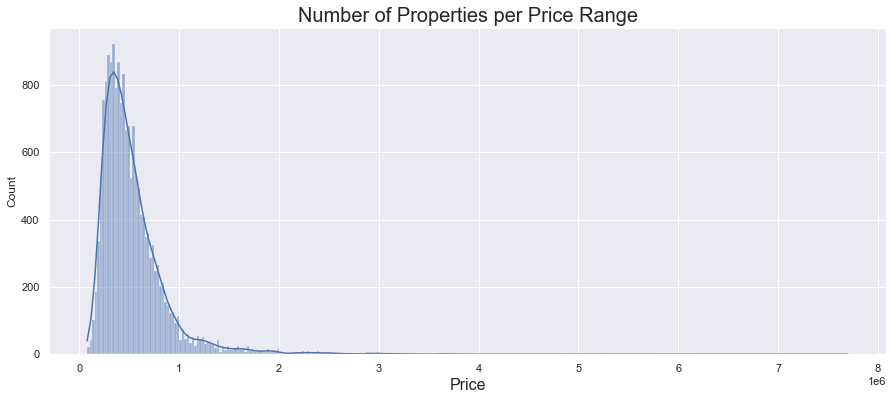

In [967]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Price', size=16)
ax.set_title('Number of Properties per Price Range', size=20)
sns.histplot(data=df, x=df['price'], kde=True, ax=ax);

We can see above that property prices are fairly normally distributed with quite a bit of skew. We can normalize it further by scalling it logarithmically.

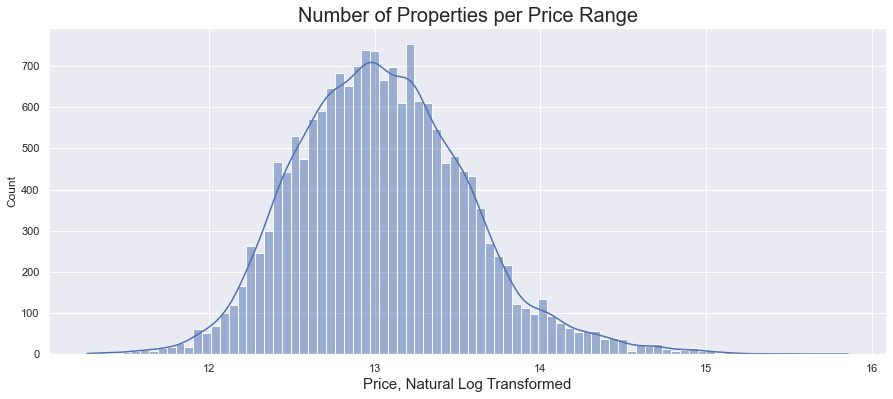

In [966]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Price, Natural Log Transformed', size=15)
ax.set_title('Number of Properties per Price Range', size=20)
sns.histplot(data=df, x=np.log(df['price']), kde=True, ax=ax);

# bedrooms
- 1 listing with **33 BEDROOMS**. Super outlier. Changed to 3 (median, and likely intended data entry). 
- Scaling down likely best practice over dropping, unless data is wrong.
- 1620 sq_ft living with 6000 sqft_lot, and $\$$640,000 sale price
- 12 properties with 0 bedrooms
  - We will correct for the outliers by:
    - 33 bedroom value imputed to 3
    - properties with more than 8 bedrooms capped down to 8, where prices begin to come down.
    - 12 properties with 0 bedrooms capped up to 1
    - We will leave properties that have 1, despite being below the IQR min

In [237]:
df.bedrooms.value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [233]:
df[df.bedrooms == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation
8597,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700,6,74,74


In [235]:
df.bedrooms.median()

3.0

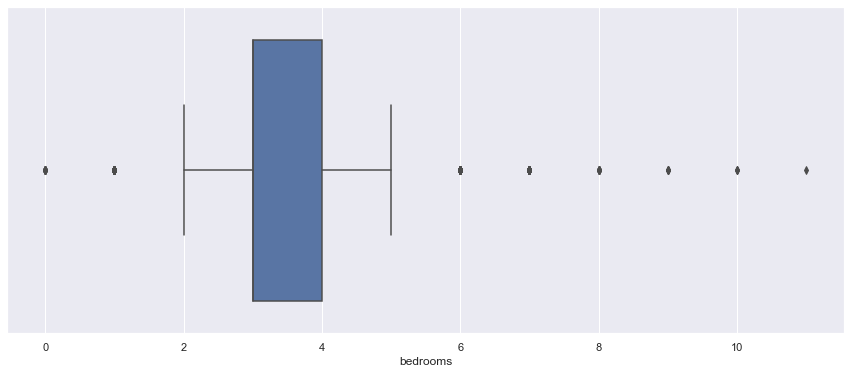

In [650]:
# fig, ax = plt.subplots(figsize=(15,6))
# sns.boxplot(x=df.bedrooms, ax=ax);

In [736]:
df['bedrooms'] =  np.where(df['bedrooms'] >5, # CLEANING: Caps total number of bedrooms to IQR max
                                      5, 
                                      df.bedrooms)

df = df[df.bedrooms != 0] # CLEANING: drops properties with 0 bedrooms

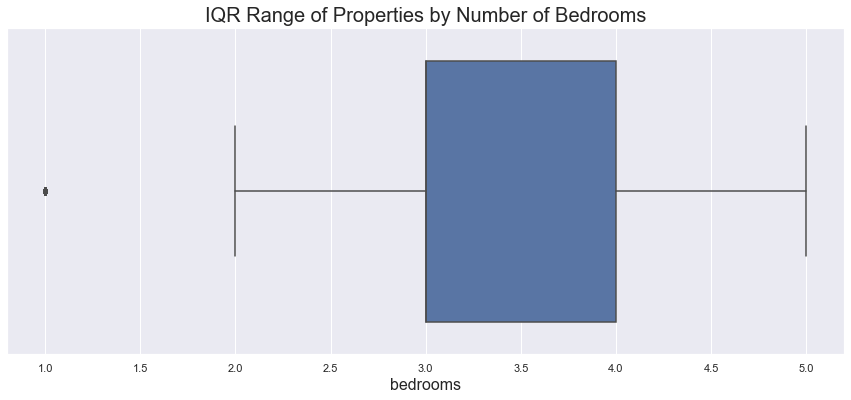

In [964]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('IQR Range of Properties by Number of Bedrooms', size=20)
ax.set_xlabel('Bedrooms', size=16)
sns.boxplot(x=df.bedrooms, ax=ax);

In [41]:
df[df.bedrooms == 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
483,3374500520,20150429,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
1120,6306400140,20140612,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
2430,1222029077,20141029,265000.0,0,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
3032,7849202190,20141223,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
3609,2569500210,20141117,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
5424,3918400017,20150205,380000.0,0,0.00,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
6409,1453602309,20140805,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
9286,2954400190,20140624,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
10067,3980300371,20140926,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
10074,2310060040,20140925,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685


In [738]:
df[df.bedrooms == 1]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living,rural,within_seattle_city_limits,sale_month,sale_year,sale_season_spring,sale_season_winter,sale_season_summer,sale_season_fall
27,2014-12-18,275000.0,1,1.00,520,4800,1.0,0,0,3,5,520,0,1930,0,98106,47.5533,-122.363,800,4960,6,91,91,85,4280.000000,528.846154,0,1,12,2014,0,0,0,1
89,2014-05-16,540000.0,1,1.00,1140,6700,1.5,0,0,3,7,1140,0,1920,0,98103,47.6958,-122.357,1350,6700,6,101,101,95,5940.000000,473.684211,0,1,5,2014,1,0,0,0
117,2014-10-29,385195.0,1,1.00,710,6000,1.5,0,0,3,6,710,0,2015,0,98144,47.5756,-122.316,1440,4800,6,6,6,0,5526.666667,542.528169,0,1,10,2014,0,0,0,1
289,2014-11-04,295000.0,1,1.00,520,5600,1.0,0,0,3,6,520,0,1918,0,98116,47.5579,-122.395,1030,5265,6,103,103,97,5080.000000,567.307692,0,1,11,2014,0,0,0,1
367,2015-04-07,250000.0,1,1.50,1180,1688,2.0,0,0,3,8,1070,110,2007,0,98126,47.5490,-122.372,1380,2059,5,14,14,9,1098.000000,211.864407,0,1,4,2015,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16964,2014-07-17,375000.0,1,1.00,720,3166,1.0,0,0,3,6,720,0,1920,0,98116,47.5811,-122.389,1140,6250,6,101,101,95,2446.000000,520.833333,0,1,7,2014,0,0,1,0
17093,2014-11-19,290000.0,1,1.00,550,5700,1.0,0,0,2,6,550,0,1916,0,98117,47.6846,-122.366,1100,4560,6,105,105,99,5150.000000,527.272727,0,1,11,2014,0,0,0,1
17111,2014-05-21,420850.0,1,1.00,960,40946,1.0,0,0,5,5,960,0,1945,0,98014,47.6951,-121.864,1320,20350,6,76,76,70,39986.000000,438.385417,1,0,5,2014,1,0,0,0
17163,2015-05-04,351000.0,1,0.75,930,6600,1.0,0,0,3,6,930,0,1924,0,98125,47.7127,-122.296,1590,6600,5,97,97,92,5670.000000,377.419355,0,1,5,2015,1,0,0,0


In [272]:
df.groupby('bedrooms')['price'].median()

bedrooms
0     304000.0
1     310000.0
2     370000.0
3     411100.0
4     550000.0
5     612995.0
6     655000.0
7     760000.0
8     854000.0
9     700000.0
10    660000.0
11    520000.0
Name: price, dtype: float64

In [276]:
df.bedrooms.value_counts()

3     7865
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
Name: bedrooms, dtype: int64

In [38]:
df.bedrooms.value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

managing 33 bedroom listing **DONE — imputed to 3**:
- plugging in the lat/long reveals a street with several nice, but modest homes. 
- Most likely the property has somewhere closer to the median 3 bedrooms, which would make sense if 33 was entered erroneously in place of 3.
- There is one interesting looking property tucked away on street view that could be a sort of residential complex, but it doesn’t look that big from what I can take away.
- Either way, when building a model, scaling down outliers to within a boxplot max would likely be necessary. Alternatively, impute to median. Could manage with both methods if using another factor for conditions, e.g. ‘sqft_living’ or geofence engineered feature.

managing listed with seemingly high bedroom counts **DONE — capped to 5, the IQR max**:
- value counts for each # of bedrooms begin to get significantly lower past 5
- should cap bedrooms for listed over 5, 6, 7, or 8.
  - argument in favor of over 5 or 6:
    - fractional dropoff for number of listings in this range
  - argument in favor of over 8:
    - prices begin to get lower after this value. 

managing listed with <1 bedroom counts **DONE — imputed to 1**:
- could impute 1, or median of properties grouped by sq_ft range
  - could use confidence interval to determine ranges for what is probable for each number of bedrooms possible

In [238]:
df[df.bedrooms == 10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation
3680,8812401450,2014-12-29,660000.0,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745,6,108,108
11181,627300145,2014-08-14,1148000.0,10,5.25,4590,10920,1.0,0,2,3,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400,6,13,13
17114,5566100170,2014-10-29,650000.0,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914,6,63,63


- first is small residence. likely data entry error but unsure what to impute. 
  - has 3 bathrooms which should indicate more bedrooms.
  - ALMOST CERTAINLY has had a renovation since 1913 but lists none. That, or the quality of architectural integrity was at its zenith just before WW1. 
- second appears to be 
groupby # bedrooms and median price, mean price

In [239]:
df[df.bedrooms == 11]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation
2356,1773100755,2014-08-21,520000.0,11,3.0,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.556,-122.363,1420,4960,6,103,22


# bathrooms
- Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- can be considered categorical as they are countable, not constant
  - form in to dummy variables if used in model
- **capping** number of bathrooms **down to 4** to account for outliers.
  - properties with more than 4 bathrooms only account for ~1% of total properties.
- **capping** properties with less than .75 bathrooms **up to .75**.

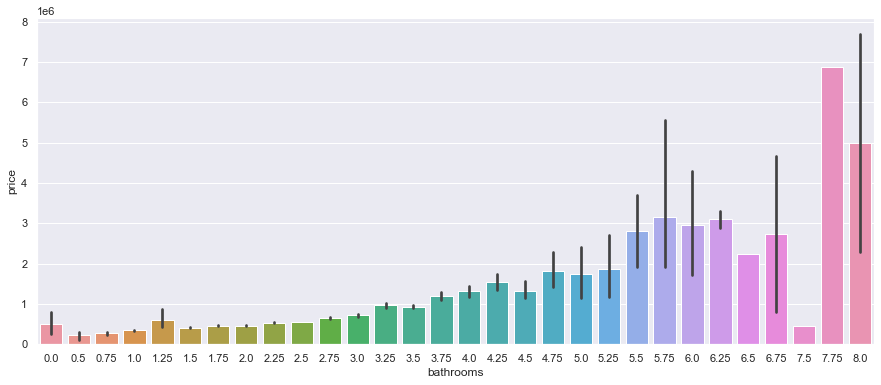

In [385]:
# fig, ax = plt.subplots(figsize=(15,6))
# sns.barplot(x=df.bathrooms, y=df.price, ax=ax);

#### Post cleaning:

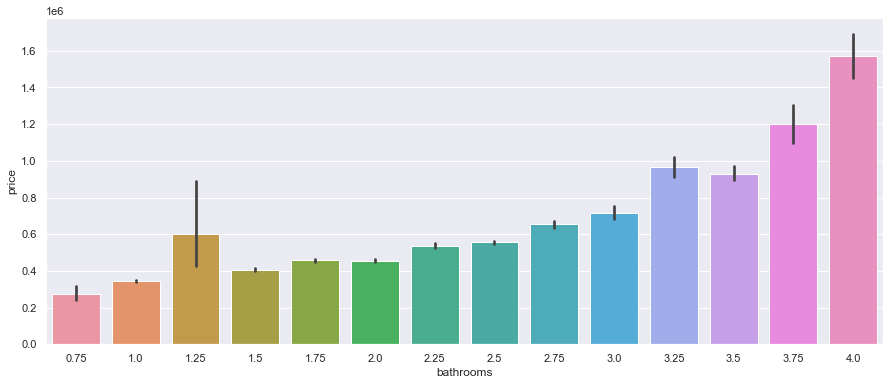

In [744]:
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x=df.bathrooms, y=df.price, ax=ax);

In [721]:
df[df.bathrooms == 0] # dropped

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living,rural,within_seattle_city_limits,sale_month,sale_year,sale_season_spring,sale_season_winter,sale_season_summer,sale_season_fall
483,2015-04-29,355000.0,0,0.0,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050,5,31,31,26,6819.000000,144.308943,0,0,4,2015,1,0,0,0
1120,2014-06-12,1095000.0,0,0.0,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000,6,31,31,25,3888.571429,357.375979,0,1,6,2014,1,0,0,0
3032,2014-12-23,235000.0,0,0.0,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200,6,25,25,19,4065.000000,159.863946,1,0,12,2014,0,0,0,1
5424,2015-02-05,380000.0,0,0.0,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399,6,15,15,9,489.000000,258.503401,0,1,2,2015,0,1,0,0
9060,2015-02-17,75000.0,1,0.0,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882,6,55,55,49,42707.000000,111.940299,1,0,2,2015,0,1,0,0
9286,2014-06-24,1295650.0,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061,6,31,31,25,25603.000000,269.365904,0,0,6,2014,1,0,0,0
10067,2014-09-26,142000.0,0,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850,6,58,58,52,20585.000000,489.655172,1,0,9,2014,0,0,1,0
12982,2014-09-18,484000.0,1,0.0,690,23244,1.0,0,0,4,7,690,0,1948,0,98053,47.6429,-121.955,1690,19290,6,73,73,67,22554.000000,701.449275,1,0,9,2014,0,0,1,0


In [583]:
df[df.bathrooms == 7.5] # capped

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living
3425,2014-08-11,450000.0,9,7.5,4050,6504,2.0,0,0,3,7,4050,0,1996,0,98144,47.5923,-122.301,1448,3866,6,25,25,19,4479.0,111.111111


In [720]:
len(df[df.bathrooms > 4]-df[df.bathrooms > 5.5]) 

209

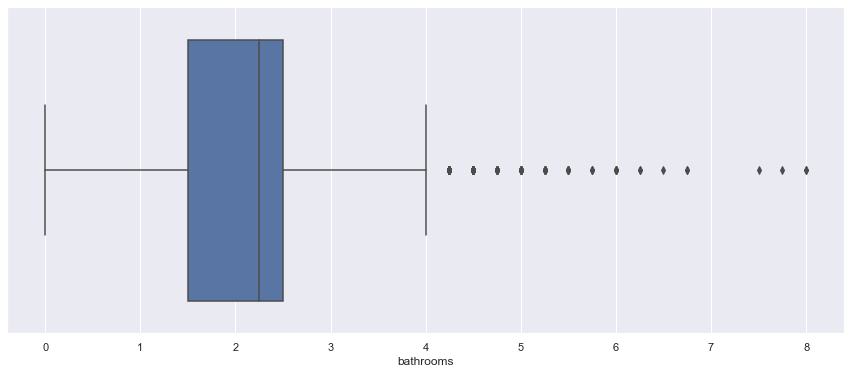

In [717]:
# fig, ax = plt.subplots(figsize=(15,6))
# sns.boxplot(x=df.bathrooms, ax=ax);

#### Post cleaning:

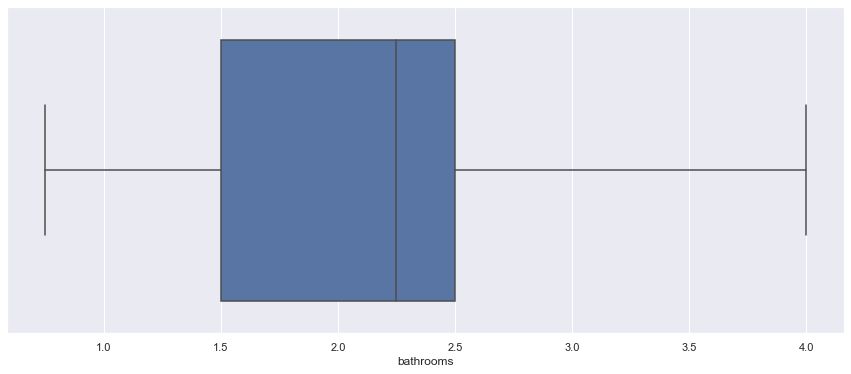

In [745]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=df.bathrooms, ax=ax);

In [741]:
df[df.bathrooms == 0.5]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living,rural,within_seattle_city_limits,sale_month,sale_year,sale_season_spring,sale_season_winter,sale_season_summer,sale_season_fall
4622,2014-08-14,255000.0,1,0.5,880,1642,1.0,0,0,3,6,500,380,1910,0,98126,47.5732,-122.372,1410,2992,6,111,111,105,762.0,289.772727,0,1,8,2014,0,0,1,0
7093,2015-01-14,109000.0,2,0.5,580,6900,1.0,0,0,3,5,580,0,1941,0,98118,47.5135,-122.262,1570,5040,6,80,80,74,6320.0,187.931034,0,1,1,2015,0,1,0,0
12674,2014-12-12,312500.0,4,0.5,2300,5570,2.0,0,0,3,8,2300,0,1996,0,98092,47.3285,-122.168,1820,6371,6,25,25,19,4420.0,135.869565,0,0,12,2014,0,0,0,1


In [747]:
len(df[df.bathrooms == 0.75]) # 51

51

In [716]:
df[df.bathrooms > 5.5]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living,rural,within_seattle_city_limits,sale_month,sale_year,sale_season_spring,sale_season_winter,sale_season_summer,sale_season_fall
1327,2015-02-19,900000.0,5,6.00,7120,40806,2.0,0,4,3,12,5480,1640,2007,0,98006,47.5451,-122.114,3440,36859,6,14,14,8,37246.000000,126.404494,0,0,2,2015,0,1,0,0
2232,2014-08-04,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345,6,20,20,14,30469.000000,605.434783,0,0,8,2014,0,0,1,0
2505,2014-10-07,800000.0,7,6.75,7480,41664,2.0,0,2,3,11,5080,2400,1953,0,98166,47.4643,-122.368,2810,33190,6,68,68,62,37924.000000,106.951872,0,0,10,2014,0,0,0,1
3168,2014-05-09,2238890.0,5,6.50,7270,130017,2.0,0,0,3,12,6420,850,2010,0,98027,47.5371,-121.982,1800,44890,6,11,11,5,126382.000000,307.962861,0,0,5,2014,1,0,0,0
3193,2015-02-09,1940000.0,4,5.75,7220,223462,2.0,0,4,3,12,6220,1000,2000,0,98053,47.7097,-122.013,2680,7593,6,21,21,15,219852.000000,268.698061,0,0,2,2015,0,1,0,0
3275,2014-05-05,2280000.0,7,8.00,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800,6,22,22,16,303238.666667,168.389956,0,0,5,2014,1,0,0,0
3425,2014-08-11,450000.0,9,7.50,4050,6504,2.0,0,0,3,7,4050,0,1996,0,98144,47.5923,-122.301,1448,3866,6,25,25,19,4479.000000,111.111111,0,1,8,2014,0,0,1,0
3833,2014-08-22,1488000.0,5,6.00,6880,279968,2.0,0,3,3,12,4070,2810,2007,0,98045,47.4624,-121.779,4690,256803,6,14,14,8,276528.000000,216.279070,1,0,8,2014,0,0,1,0
4217,2014-06-11,2888000.0,5,6.25,8670,64033,2.0,0,4,3,13,6120,2550,1965,2003,98177,47.7295,-122.372,4140,81021,6,56,18,12,59698.000000,333.102653,0,1,6,2014,1,0,0,0
5039,2015-04-13,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619,5,30,30,25,21134.000000,717.185386,0,0,4,2015,1,0,0,0


In [393]:
baths = df[df.bathrooms < 5.75]

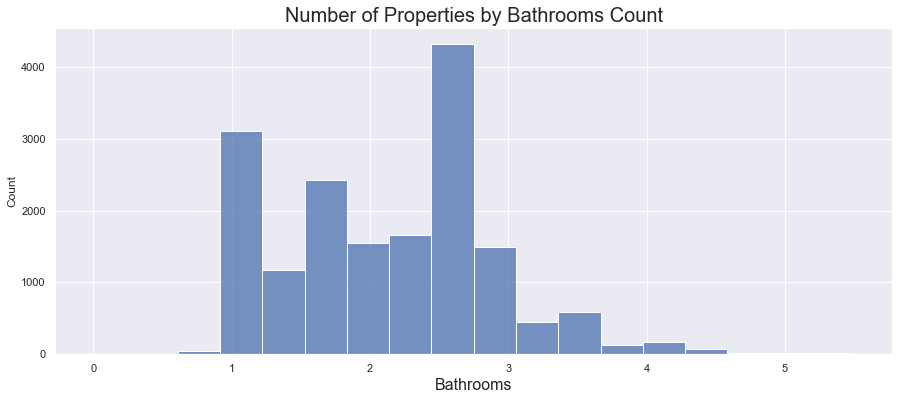

In [963]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Number of Properties by Bathrooms Count', size=20)
ax.set_xlabel('Bathrooms', size=16)
sns.histplot(baths.bathrooms, ax=ax, bins=18);

# sqft_living
- Square footage of the apartments interior living space
- EDA:
  - excellent indicator of price, with variance increasing as sqft_living goes up.
  - furthest points out are not outliers
  - curious to see this broken in to within Seattle, outside Seattle suburban, and Rural

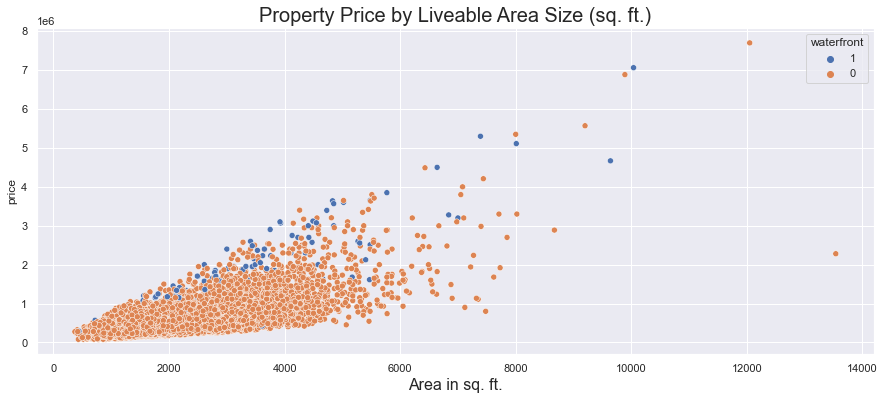

In [961]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Price by Liveable Area Size (sq. ft.)', size=20)
ax.set_xlabel('Area in sq. ft.', size=16)
sns.scatterplot(data=df, x=df.sqft_living, y=df.price, hue='waterfront', hue_order=[1, 0], ax=ax);

In [464]:
df[df['sqft_living'] > 12000]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living
3275,2014-05-05,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800,6,22,22,16,303238.666667,168.389956
10366,2014-10-13,7700000.0,6,8.0,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,6,111,34,28,22780.000000,639.004149


# sqft_lot
- Square footage of the land space (total property)
- I'm not entirely sure if I'm interpreting the natural log groupby histogram below well, worth asking Sean for help understanding. 
- used this to create sqft_yard:
  - sqft_lot-(sqft_living/floors)

<AxesSubplot:title={'center':'Property Price by Lot Area Size (sq. ft.)'}, xlabel='Area in sq. ft.', ylabel='price'>

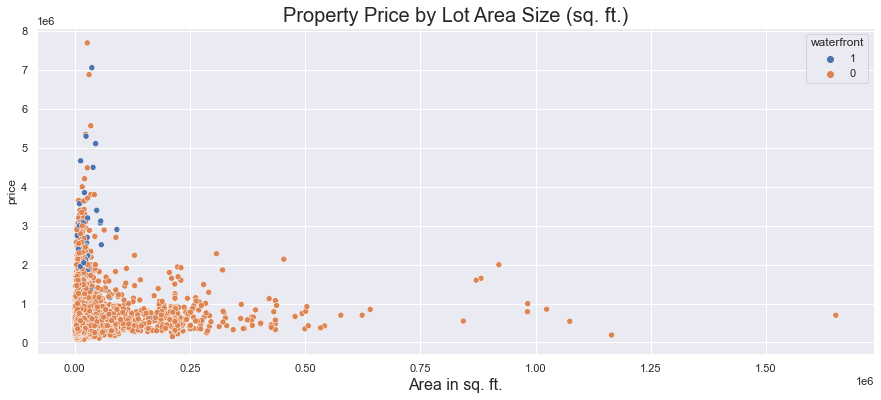

In [960]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Price by Lot Area Size (sq. ft.)', size=20)
ax.set_xlabel('Area in sq. ft.', size=16)
sns.scatterplot(data=df, x=df.sqft_lot, y=df.price, hue='waterfront', hue_order=[1, 0], ax=ax)

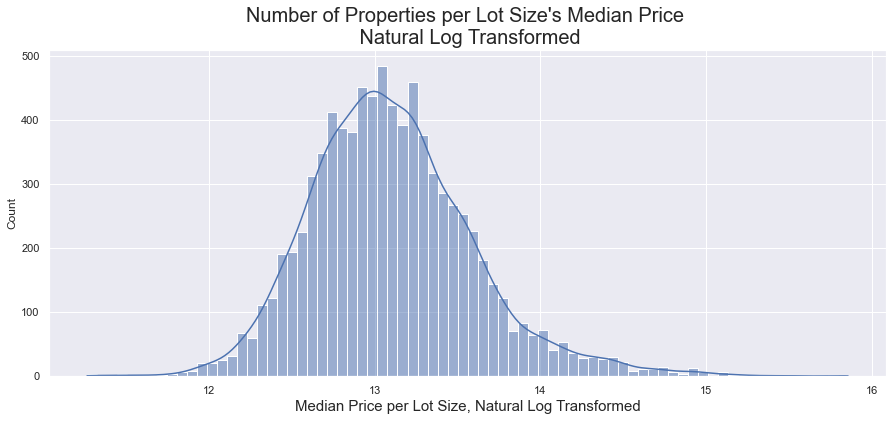

In [950]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Median Price per Lot Size, Natural Log Transformed', size=15)
ax.set_title('Number of Properties per Lot Size\'s Median Price \n Natural Log Transformed', size=20)
sns.histplot(data=df, x=np.log(df.groupby('sqft_lot')['price'].median()), kde=True, ax=ax);
# sns.histplot(data=df, x=df['sqft_lot'], kde=True, log_scale=10, ax=ax);

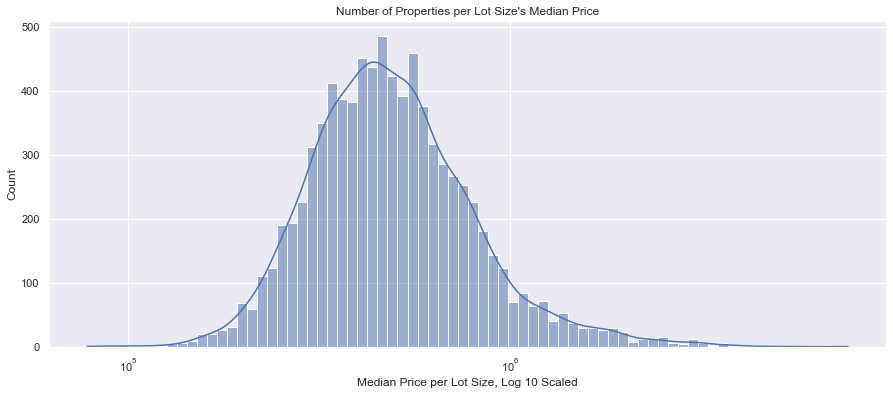

In [951]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Median Price per Lot Size, Log 10 Scaled')
ax.set_title('Number of Properties per Lot Size\'s Median Price')
sns.histplot(data=df, x=df.groupby('sqft_lot')['price'].median(), kde=True, log_scale=10, ax=ax);
# sns.histplot(data=df, x=df['sqft_lot'], kde=True, log_scale=10, ax=ax);

In [953]:
# stats.ttest_1samp(a, popmean, axis=0, nan_policy='omit', alternative='two-sided')

# floors
- Number of floors
- may be useful to drop AFTER use in creating other features, such as sqft_lawn

In [ ]:
df[df.floors == 0] # checking for errors in data entry, no mistakes
df[df.floors > 3] # no severe outliers, though I wonder what .5 floors looks like

# waterfront
- A dummy variable for whether the apartment was overlooking the waterfront or not
- dang this adds an average of $\$$1,156,981 to property value.

In [262]:
df.waterfront.value_counts()

0    17152
1      138
Name: waterfront, dtype: int64

In [288]:
df[df.waterfront == 1].price.mean() - df[df.waterfront == 0].price.mean()

1156981.0605734913

In [263]:
df[df.waterfront == 1].price.mean()

1688486.1739130435

In [264]:
df[df.waterfront == 1].price.median()

1405000.0

In [265]:
df[df.waterfront == 0].price.mean()

531505.1133395522

In [267]:
df[df.waterfront == 0].price.median()

450000.0

In [268]:
df[df.waterfront == 1].price.max()

7062500.0

In [270]:
df[df.price == 7062500.0]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard
6903,2014-06-11,7062500.0,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449,6,81,20,14,32305.0


In [511]:
df[df.waterfront == 0].price

0         365000.0
1         865000.0
2        1038000.0
3        1490000.0
4         711000.0
           ...    
17285     750000.0
17286     440000.0
17287     310000.0
17288     427500.0
17289     348000.0
Name: price, Length: 17152, dtype: float64

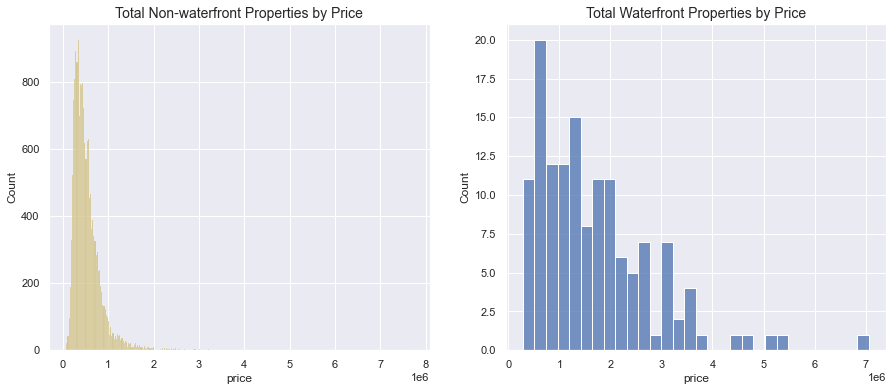

In [1139]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].set_title('Total Non-waterfront Properties by Price', size=14)
ax[1].set_title('Total Waterfront Properties by Price', size=14)
#         plt.set_title('Number of Properties at Different Prices', size=16, loc='center', y=1.0, pad=5.0);)
sns.histplot(data=df, x=df[df.waterfront == 0].price, 
             color = 'y', ax = ax[0])
sns.histplot(data=df, x=df[df.waterfront == 1].price, 
             color = 'b', bins = 30, ax = ax[1]);

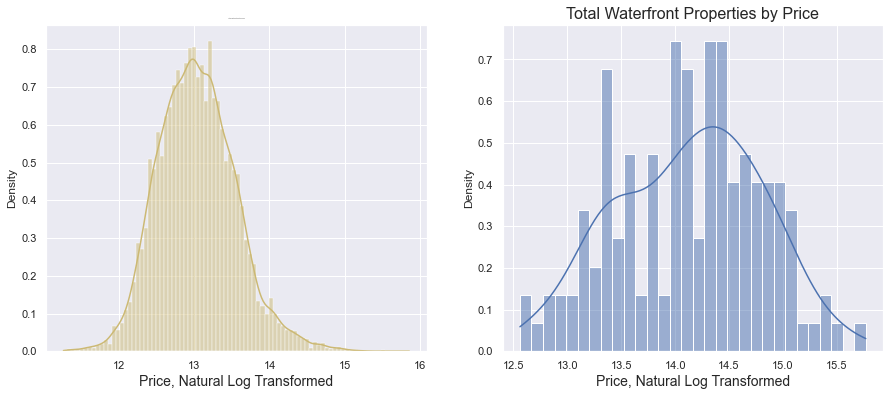

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].set_title('Total Non-waterfront Properties by Price', size=1)
ax[1].set_title('Total Waterfront Properties by Price', size=16)
ax[0].set_xlabel('Price, Natural Log Transformed', size = 14)
ax[1].set_xlabel('Price, Natural Log Transformed', size = 14)
#         plt.set_title('Number of Properties at Different Prices', size=16, loc='center', y=1.0, pad=5.0);)
sns.histplot(data=df, x=np.log(df[df.waterfront == 0].price),
             color = 'y', kde=True, stat='density', ax = ax[0])
sns.histplot(data=df, x=np.log(df[df.waterfront == 1].price),
             color = 'b', kde=True, stat='density', bins = 30, ax = ax[1]);

- Scaling size to match can be a bit misleading. See below.

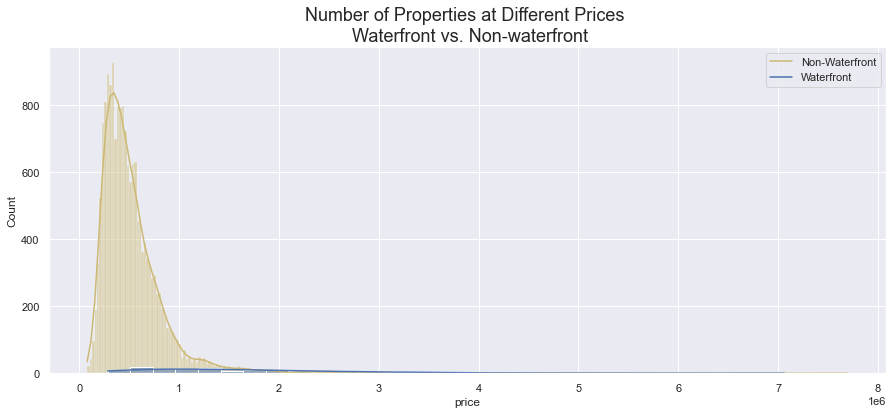

In [55]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Number of Properties at Different Prices \n Waterfront vs. Non-waterfront', size = 18)

sns.histplot(data=df, x=df[df.waterfront == 0].price, 
             color = 'y', label = 'Non-Waterfront', kde=True, ax = ax)
sns.histplot(data=df, x=df[df.waterfront == 1].price, 
             color = 'b', label = 'Waterfront', bins = 30, kde=True, ax = ax)
ax.legend(labels=['Non-Waterfront', 'Waterfront']);

- It's difficult to takeaway much about how the distribution of waterfront property sales per sale price.
- We can get a better view of a distribution comparison using by plotting the density of properties per sale price.

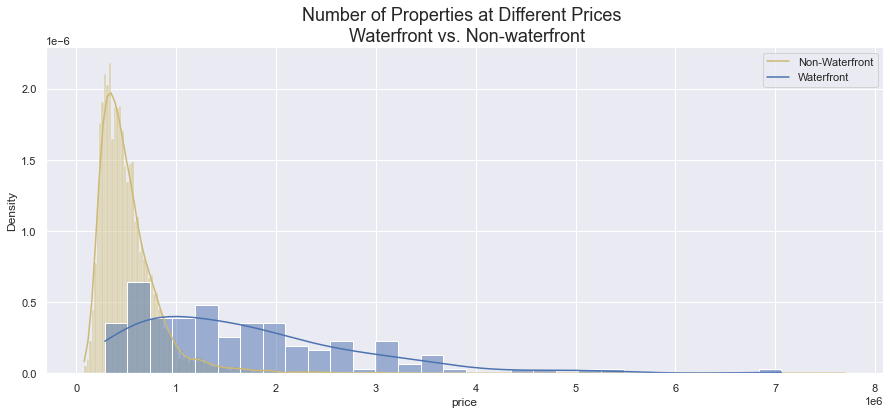

In [45]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Number of Properties at Different Prices \n Waterfront vs. Non-waterfront', size = 18)

sns.histplot(data=df, x=df[df.waterfront == 0].price, 
             color = 'y', label = 'Non-Waterfront', kde=True, stat='density', ax = ax)
sns.histplot(data=df, x=df[df.waterfront == 1].price, 
             color = 'b', label = 'Waterfront', bins = 30, kde=True, stat='density', ax = ax)
ax.legend(labels=['Non-Waterfront', 'Waterfront']);

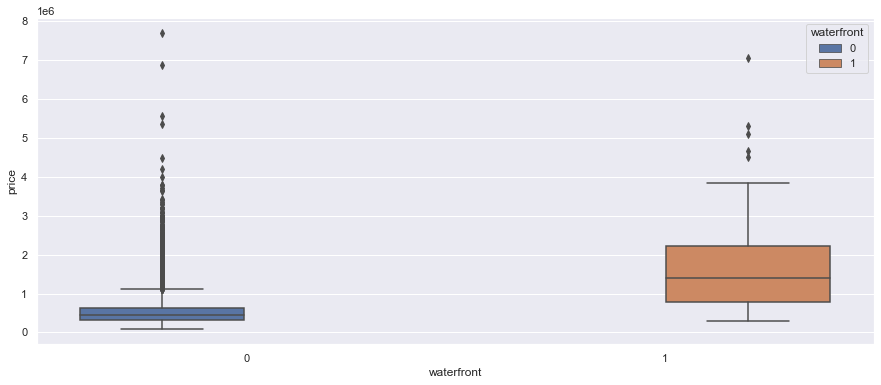

In [509]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Waterfront vs. Non-waterfront Property Values')
sns.boxplot(data=df, x='waterfront', y='price', hue='waterfront');

# view
- An index from 0 to 4 of how good the view of the property was
- **MANY VALUES = 0**, though may be enough in each other view rating to be useful.
  - However, higher-view rating categories seem to be dominated by 'waterfront' properties. 
  - this is despite the fact that waterfront properties make up less than 1% of the data.
- tempted to drop. seems far too subjective of a category, which suggests there will be no consistency among the ratings.
  - this could be corrected for if there are objective measures for how this is done, but without further details on the data collection methods, this is impossible to tell
  - when testing model, will test with view, and with waterfront seperately

In [529]:
df.view.value_counts()

0    15571
2      775
3      410
4      270
1      264
Name: view, dtype: int64

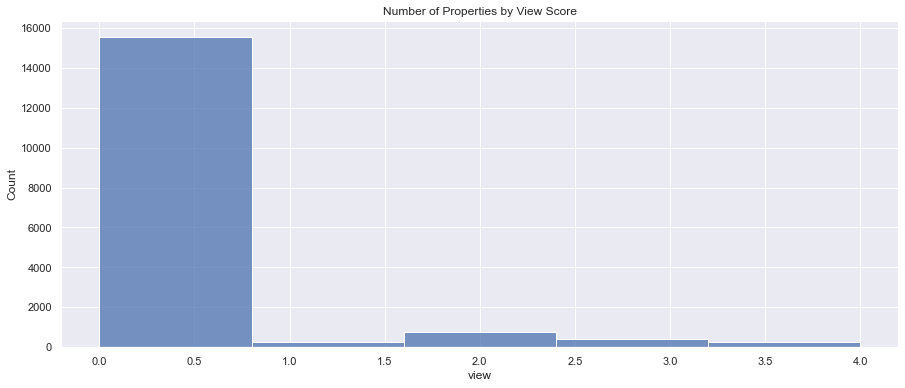

In [877]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Number of Properties by View Score')
sns.histplot(data=df, x=df['view'], ax=ax, bins = 5);

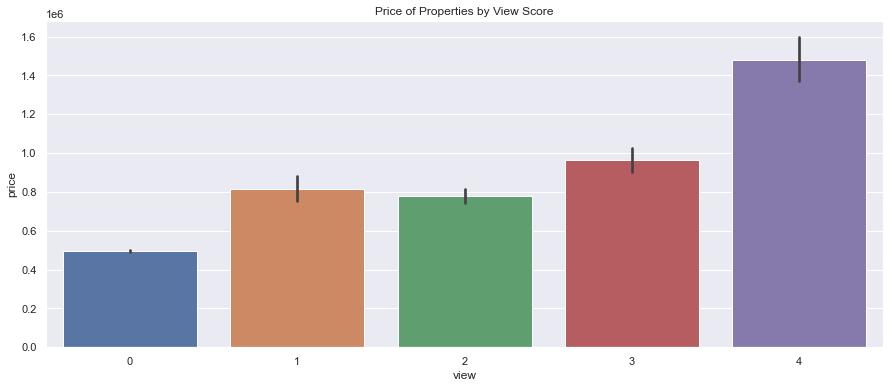

In [875]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price of Properties by View Score')
sns.barplot(data=df, x=df.view, y=df.price, ax=ax);

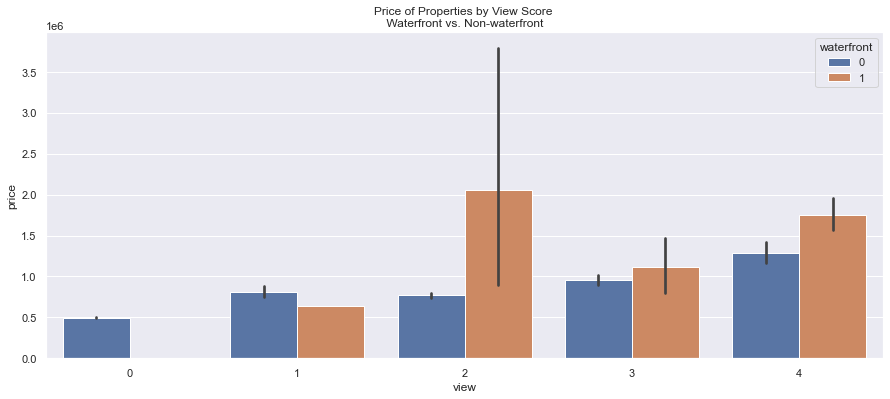

In [874]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price of Properties by View Score \n Waterfront vs. Non-waterfront ')
sns.barplot(data=df, x=df.view, y=df.price, hue='waterfront', ax=ax);

In [538]:
df[df.waterfront == 0].value_counts().sum()

17152

In [537]:
df[df.waterfront == 1].value_counts().sum()

138

In [543]:
df[df.waterfront == 1].value_counts().sum()/df[df.waterfront == 0].value_counts().sum()

0.008045708955223881

In [291]:
df[df.view == 0].price.mean()

496770.421231777

In [292]:
df[df.view == 1].price.mean()

813770.178030303

In [293]:
df[df.view == 2].price.mean()

779421.2193548387

In [294]:
df[df.view == 3].price.mean()

964004.756097561

In [295]:
df[df.view == 4].price.mean()

1481651.2777777778

# condition
- An index from 1 to 5 on the condition of the apartment
- Note: could cause multiple colinearity with yrs_since_renovation_at_sale (and others)

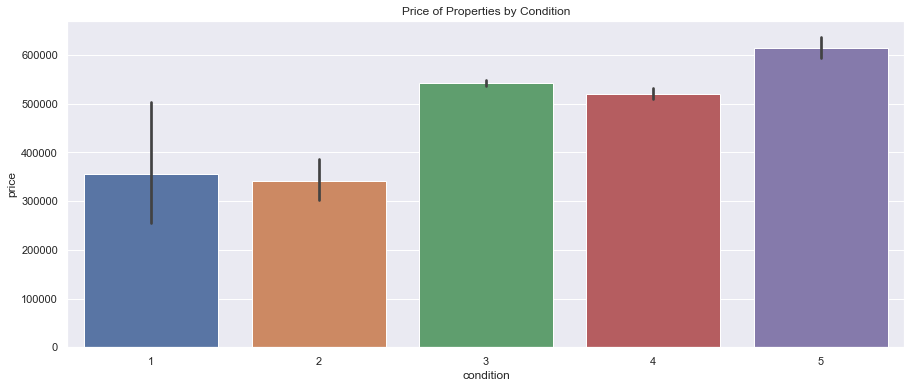

In [872]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price of Properties by Condition')
sns.barplot(data=df, x=df['condition'], y=df['price'], ax=ax);

In [559]:
df.groupby('condition')['price'].median()

condition
1    262500.0
2    280000.0
3    451000.0
4    440000.0
5    530000.0
Name: price, dtype: float64

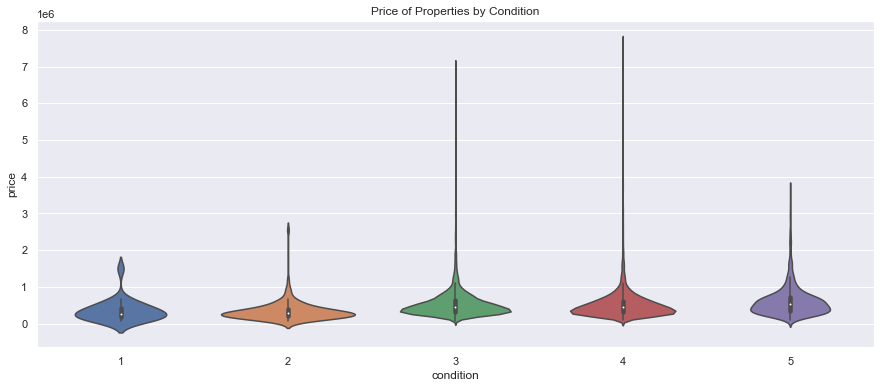

In [870]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price of Properties by Condition')
sns.violinplot(x=df.condition, y=df.price, ax=ax);

In [522]:
df[df.condition == 1].price.mean()

346372.9166666667

In [298]:
df[df.condition == 2].price.mean()

339570.7841726619

In [299]:
df[df.condition == 3].price.mean()

542532.6626645322

In [300]:
df[df.condition == 4].price.mean()

520915.7223206377

In [301]:
df[df.condition == 5].price.mean()

615348.0950987564

# grade
- An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
- Represents the construction quality of improvements. 
- ranges from 1 to 13
  - 1-3 Falls short of minimum building standards. Normally cabin or inferior structure.
  - 4 Generally older, low quality construction. Does not meet code.
  - 5 Low construction costs and workmanship. Small, simple design.
  - 6 Lowest grade currently meeting building code. Low quality materials and simple designs.
  - 7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.
  - 8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
  - 9 Better architectural design with extra interior and exterior design and quality.
  - 10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.
  - 11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.
  - 12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
  - 13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

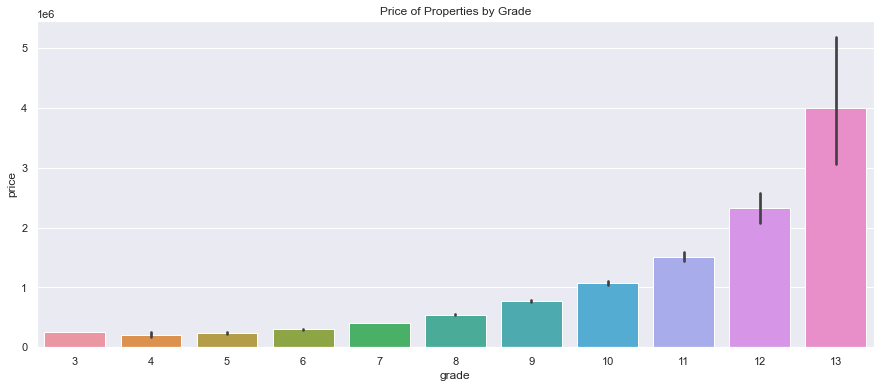

In [869]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price of Properties by Grade')
sns.barplot(data=df, x=df['grade'], y=df['price'], ax=ax);

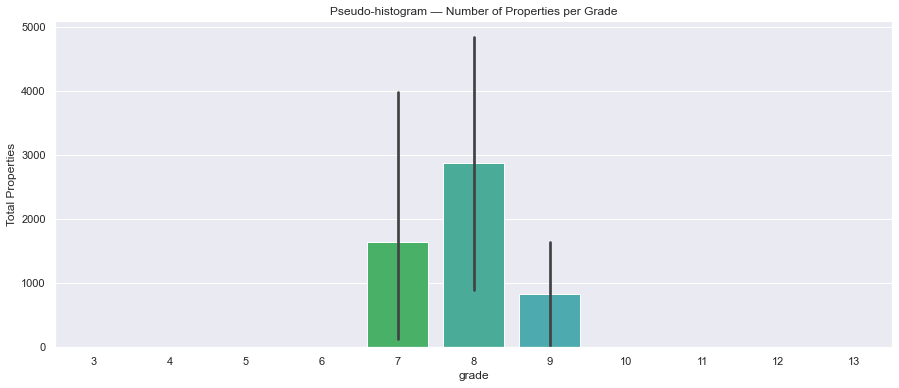

In [868]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Pseudo-histogram — Number of Properties per Grade')
sns.barplot(data=df, x=df['grade'], y=df['grade'].value_counts(), ax=ax)
ax.set_ylabel('Total Properties');

In [774]:
# df[df.grade == 3] # 1
df[df.grade == 4] # 20
df[df.grade == 5] # 191
df[df.grade == 6] # 1647
df[df.grade == 7] # 7177
df[df.grade == 8] # 4844
df[df.grade == 9] # 2099
df[df.grade == 10] # 893
df[df.grade == 11] # 319
df[df.grade == 12] # 71
df[df.grade == 13] # 11

11

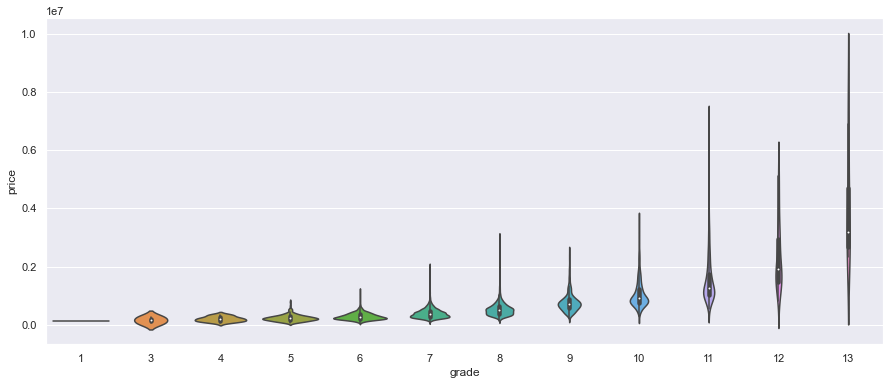

In [576]:
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(data=df, x=df['grade'], y=df['price'], ax=ax);

# sqft_above
- The square footage of the interior housing space that is above ground level
- Will likely drop from model to avoid multicolinearity with highly correlated variable **sqft_living**

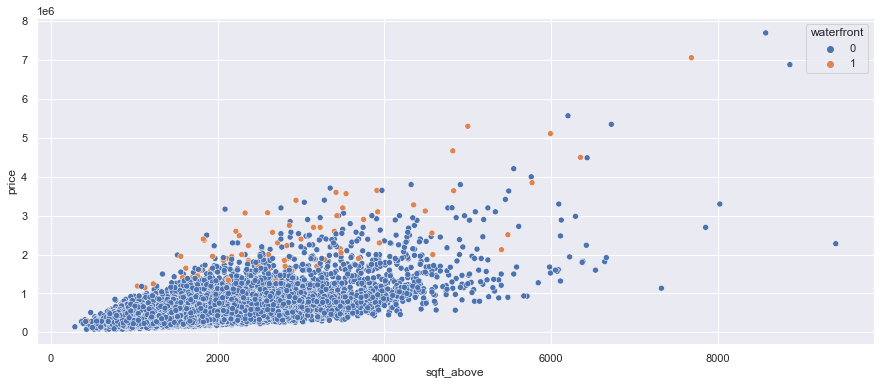

In [586]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_above, y=df.price, hue='waterfront', ax=ax);

# sqft_basement
- The square footage of the interior housing space that is below ground level
- Below, we can see many properties don't have a basement listed, which could be for the following reasons:
  - could be that this data wasn't recorded for some where it's listed 0
  - could be that they are apartment complexes and in fact don't have a basement that's private to the individual resident
  - could be that they don't have a basement

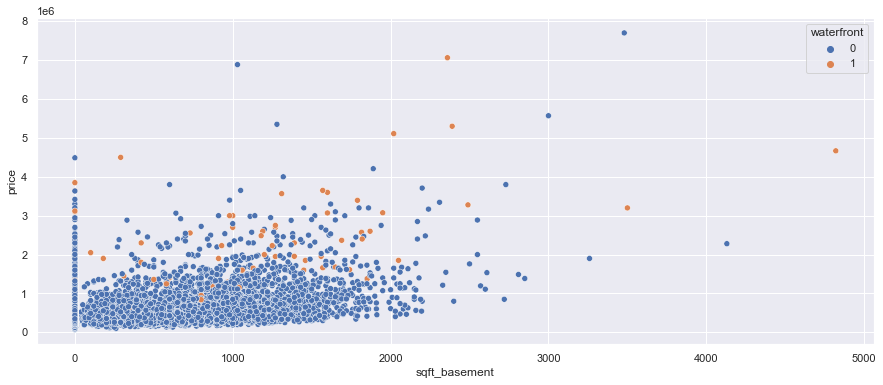

In [587]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_basement, y=df.price, hue='waterfront', ax=ax);

#### It might be useful to isolate only properties that have non-zero values for sqft_basement.

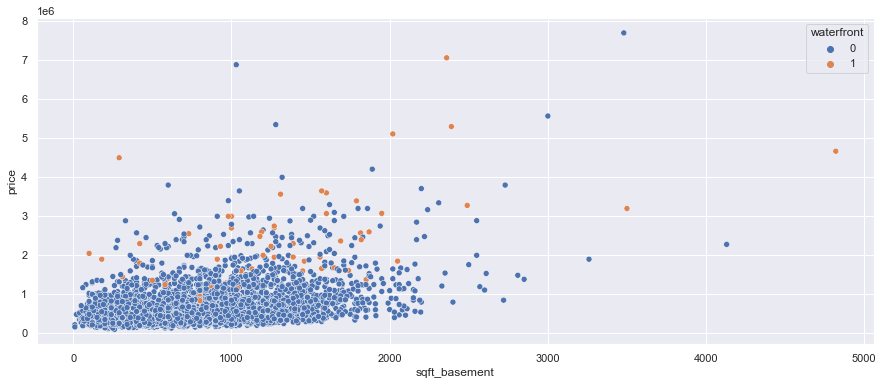

In [663]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df[df.sqft_basement != 0].sqft_basement, y=df.price, hue='waterfront', ax=ax);

# yr_built
### AFTER REVIEW THIS CATEGORY MAY BE FULL OF INSIGHTS
- The year the house was initially built
- initial takeaways: Nothing that spectacular here. Primary utility will be in what features may be engineered with this column.
  - one concern is that, in certain instances, **yr_built** is later than the sale year.
    - it is of course possible that certain buyers puchased the property before construction was finished.
    - Issues that could arrise:
      - for **yrs_since_ren_at_sale**, I will have to be careful with values that may be set negative because of this.
- further takeaways: Fascinating connections made when considering history:
  - The value of properties made during WW1 decrease as they were made later in the war
  - There seems to be a spike down, then back up for one year (may be due to outliers), then back down, for the value of properties constructed  around the Great Depression.
  - After a slight recovery of values for properties constructed on the upswing coming out of the Great Depression, there is the deepest trend downwards in value for properties built during WW2, reaching the lowest for the entire span of years.
  - Properties built after WW2 are more consistantly valued with a slow trend upwards for properties built closer to 2001.
  - Properties built shortly after 2001 are valued roughly 75% of properties built just before... certainly a reflection of the global economy after 9/11.

In [593]:
df.yr_built.describe()

count    17290.000000
mean      1970.792019
std         29.343516
min       1900.000000
25%       1951.000000
50%       1974.000000
75%       1996.000000
max       2015.000000
Name: yr_built, dtype: float64

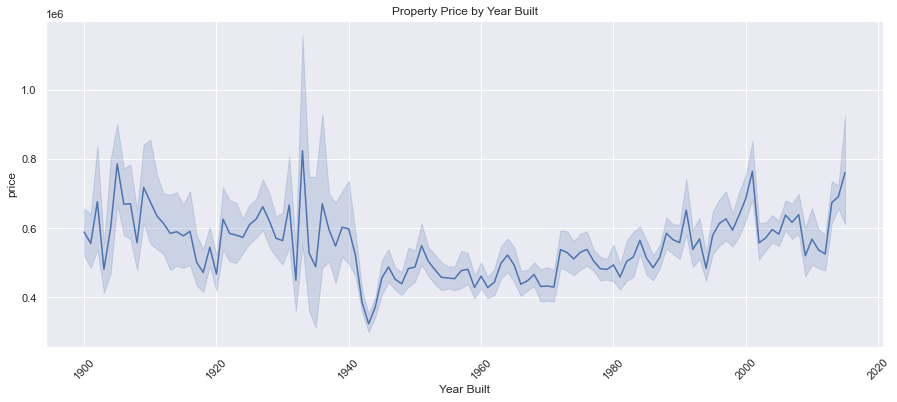

In [779]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Price by Year Built')
ax.set_xlabel('Year Built')
plt.xticks(rotation=45)
sns.lineplot(data=df, x=df.yr_built, y=df.price, ax=ax);

In [775]:
.75*10**6

750000.0

In [778]:
(.58*10**6)/(.75*10**6)

0.7733333333333333

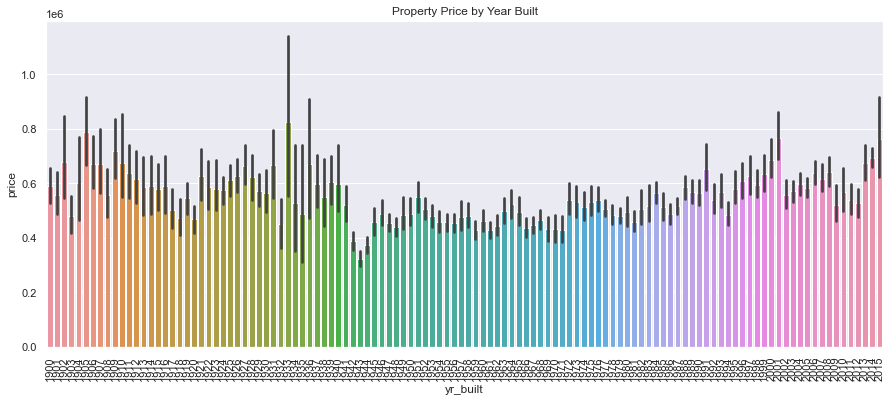

In [596]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Price by Year Built')
plt.xticks(rotation=90)
sns.barplot(data=df, x=df.yr_built, y=df.price, ax=ax);

# yr_renovated
- The year of the house’s last renovation
- having trouble manipulating this one appropriately, but I think engineered feature **'yrs_since_ren_at_sale'** will be better for insights.

In [598]:
df[df.yr_renovated == 0]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yrs_since_sale,yrs_old,yrs_since_renovation,yrs_since_ren_at_sale,sqft_yard,price_per_sqft_living
0,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,6,35,35,29,7858.000000,176.328502
1,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,6,44,44,38,3830.000000,298.275862
2,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,6,24,24,18,9008.000000,275.331565
3,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,5,31,31,26,12328.000000,326.754386
4,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,6,17,17,11,4101.000000,278.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,2015-03-03,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400,6,63,63,57,6720.000000,231.481481
17286,2014-05-20,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013,6,73,73,67,3350.000000,338.461538
17287,2014-05-14,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403,6,68,68,62,8826.000000,295.238095
17288,2014-12-04,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028,6,50,50,44,41919.333333,225.000000


In [606]:
df[df.yr_renovated > 1700].yr_renovated.value_counts()

2014    71
2007    32
2005    32
2000    31
2013    30
        ..
1951     1
1948     1
1959     1
1944     1
1934     1
Name: yr_renovated, Length: 68, dtype: int64

In [608]:
df[df.yr_renovated == 0].yr_renovated.value_counts()

0    16564
Name: yr_renovated, dtype: int64

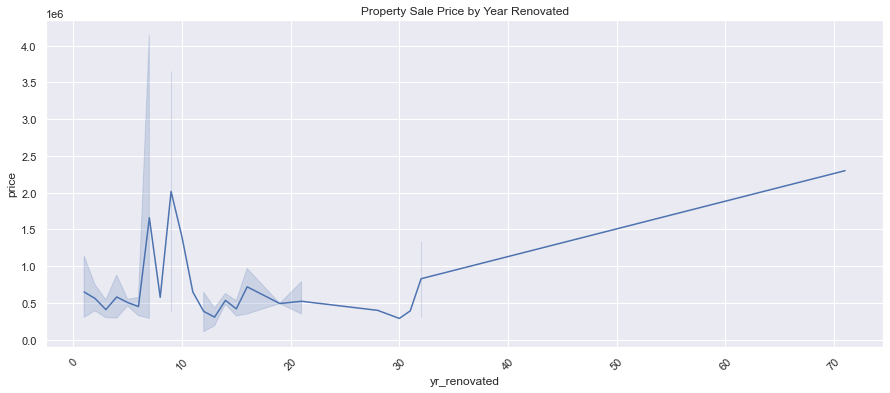

In [607]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Sale Price by Year Renovated')
plt.xticks(rotation=45)

sns.lineplot(data=df[df.yr_renovated > 1700], 
             x=df[df.yr_renovated > 1700].yr_renovated.value_counts(), 
             y=df.price, ax=ax);

# zipcode
- What zipcode area the house is in
- There is MASSIVE disparity between home prices based on zipcode. This must be controlled for in model!
- **CATEGORICAL**
- Create dummy variables

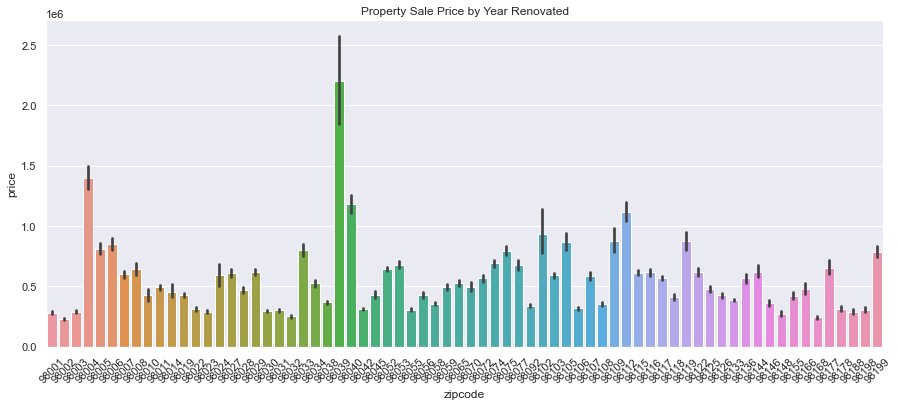

In [609]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Sale Price Comparisons by Zipcode')
plt.xticks(rotation=45)

sns.barplot(x='zipcode', y='price', data=df);

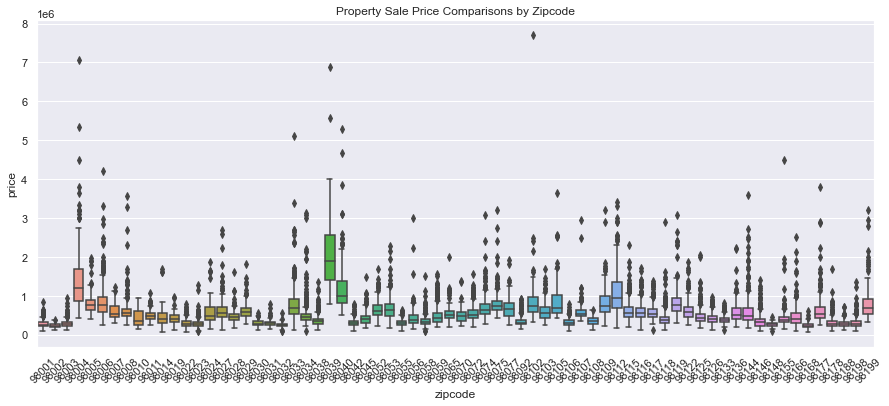

In [132]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Property Sale Price Comparisons by Zipcode')
plt.xticks(rotation=45)

sns.boxplot(x='zipcode', y='price', data=df);

In [133]:
df[df.zipcode == 98039].price.median()

1892500.0

In [134]:
df.price.median()

450000.0

In [142]:
len(df[df.price > 3000000])

42

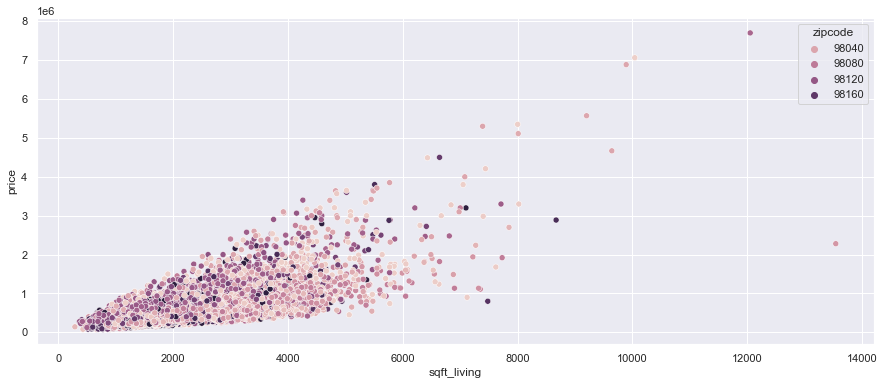

In [616]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_living, y=df.price, hue='zipcode', ax=ax);

In [247]:
df.zipcode.value_counts() # 70 different zipcodes... this is gonna be a wide-ass df

98052    474
98115    465
98103    461
98038    455
98117    437
        ... 
98102     80
98010     74
98024     65
98148     43
98039     42
Name: zipcode, Length: 70, dtype: int64

In [612]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(zipcode_dummy_df.corr())

                          price  bedrooms  bathrooms  sqft_living  sqft_lot  \
price                  1.000000  0.313775   0.524335     0.703540  0.086803   
bedrooms               0.313775  1.000000   0.524033     0.588536  0.030674   
bathrooms              0.524335  0.524033   1.000000     0.755270  0.085470   
sqft_living            0.703540  0.588536   0.755270     1.000000  0.166810   
sqft_lot               0.086803  0.030674   0.085470     0.166810  1.000000   
floors                 0.256985  0.179908   0.497967     0.357169 -0.002205   
waterfront             0.275779 -0.008668   0.065848     0.109738  0.015356   
view                   0.395485  0.082724   0.188817     0.283336  0.073058   
condition              0.036099  0.021376  -0.122976    -0.061530 -0.013715   
grade                  0.666215  0.366405   0.664191     0.762929  0.110320   
sqft_above             0.607760  0.488420   0.686853     0.876696  0.180755   
sqft_basement          0.323312  0.307873   0.282700

AttributeError: 'NoneType' object has no attribute 'max'

In [611]:
df['price'].corr(df.zipcode)

-0.0489584854338204

In [339]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('zipcode')['price_per_sqft_living'].median())

zipcode
98001    147.848438
98002    147.701149
98003    152.068841
98004    458.598726
98005    315.839361
98006    289.145907
98007    293.300881
98008    292.540569
98010    191.611074
98011    220.077220
98014    214.102564
98019    194.545455
98022    163.809524
98023    145.601586
98024    243.463035
98027    250.107759
98028    222.634508
98029    271.315789
98030    151.658768
98031    154.891304
98032    149.193548
98033    321.739130
98034    256.410788
98038    170.068027
98039    565.165614
98040    376.315789
98042    159.269912
98045    210.668563
98052    273.493721
98053    269.310828
98055    173.759710
98056    204.314641
98058    174.380165
98059    196.132597
98065    207.528958
98070    255.747126
98072    241.836735
98074    256.758607
98075    252.458803
98077    240.067646
98092    150.075758
98102    401.330614
98103    361.861862
98105    386.291949
98106    216.441441
98107    372.837617
98108    209.150327
98109    417.355372
98112    424.745797
98115    334

In [316]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('zipcode')['price'].median())

zipcode
98001     261000.0
98002     229950.0
98003     265000.0
98004    1208000.0
98005     761225.0
98006     753000.0
98007     542250.0
98008     550000.0
98010     362500.0
98011     470000.0
98014     410500.0
98019     406250.0
98022     279000.0
98023     268250.0
98024     475000.0
98027     560000.0
98028     448500.0
98029     587500.0
98030     283200.0
98031     289950.0
98032     248000.0
98033     675000.0
98034     447450.0
98038     342000.0
98039    1892500.0
98040     989900.0
98042     292500.0
98045     390000.0
98052     615000.0
98053     634900.0
98055     296725.0
98056     380000.0
98058     332000.0
98059     430000.0
98065     499900.0
98070     467500.0
98072     505000.0
98074     645000.0
98075     737444.0
98077     652475.0
98092     312750.0
98102     745000.0
98103     560000.0
98105     679500.0
98106     312000.0
98107     529975.0
98108     346500.0
98109     736000.0
98112     940000.0
98115     561500.0
98116     568000.0
98117     535610.0
9811

In [340]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('zipcode')['price'].std())

zipcode
98001    9.940111e+04
98002    5.332875e+04
98003    1.072202e+05
98004    7.980053e+05
98005    2.727417e+05
98006    4.474201e+05
98007    1.862670e+05
98008    3.832813e+05
98010    2.040606e+05
98011    1.280995e+05
98014    2.723450e+05
98019    1.259290e+05
98022    1.129660e+05
98023    1.136739e+05
98024    3.680076e+05
98027    2.848574e+05
98028    1.598076e+05
98029    1.932705e+05
98030    7.370928e+04
98031    7.392874e+04
98032    6.470881e+04
98033    4.748570e+05
98034    3.279277e+05
98038    1.389843e+05
98039    1.242894e+06
98040    6.179093e+05
98042    1.025196e+05
98045    1.910496e+05
98052    1.910254e+05
98053    2.682728e+05
98055    9.159672e+04
98056    2.392405e+05
98058    1.328835e+05
98059    2.352255e+05
98065    1.934769e+05
98070    1.988705e+05
98072    2.145114e+05
98074    2.784124e+05
98075    2.999751e+05
98077    2.663579e+05
98092    1.266444e+05
98102    8.723511e+05
98103    2.037417e+05
98105    4.823200e+05
98106    9.949839e+04
98

<AxesSubplot:title={'center':'Property Sale Price Comparisons by Zipcode'}>

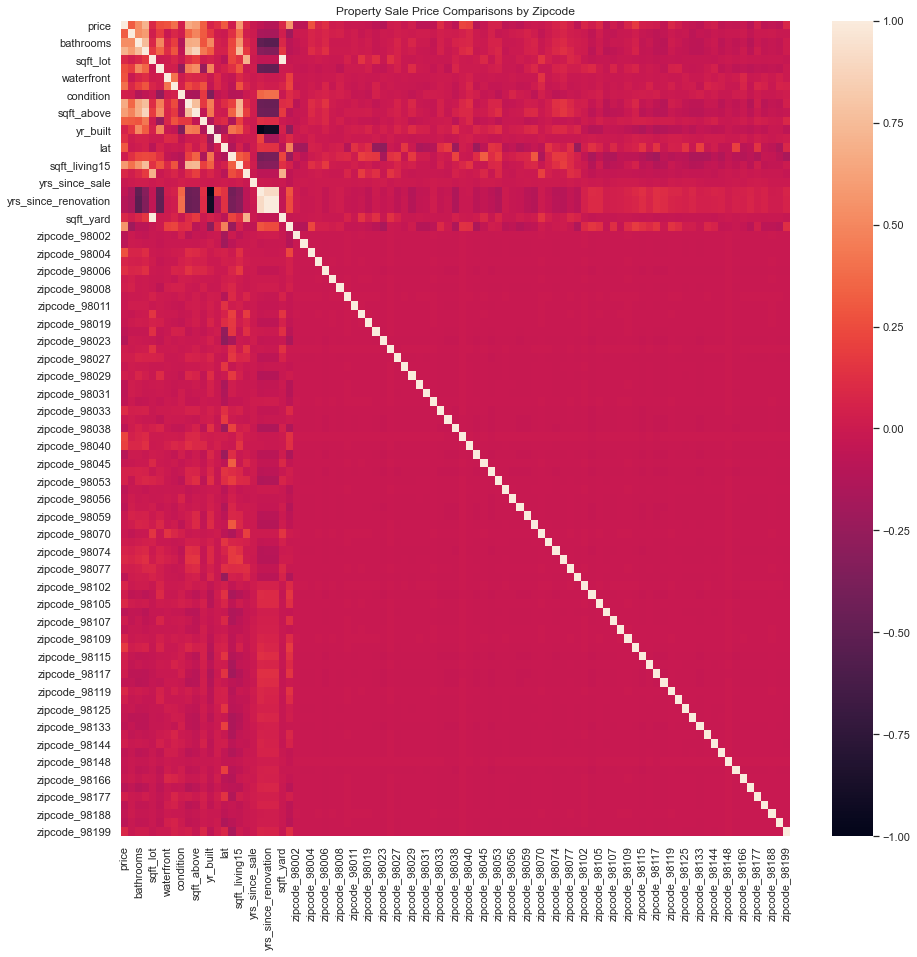

In [614]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Property Sale Price Comparisons by Zipcode')

sns.heatmap(zipcode_dummy_df.corr());

# lat
- Lattitude

# long
- Longitude
  - property values increase as long decreases, as further west 

# sqft_living15
- The mean square footage of interior housing living space for the nearest 15 neighbors
- Note: I've also seen it described as sq. ft. living after renovation, but I don't think this is accurate.

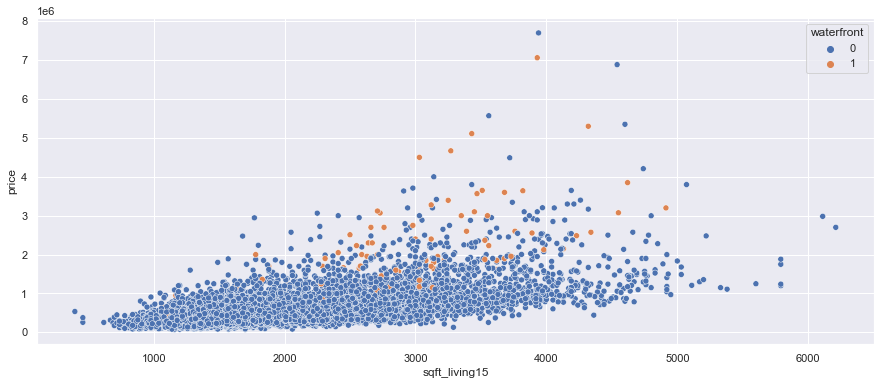

In [615]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_living15, y=df.price, hue='waterfront', ax=ax);

# sqft_lot15
- The mean square footage of lot size for the nearest 15 neighbors

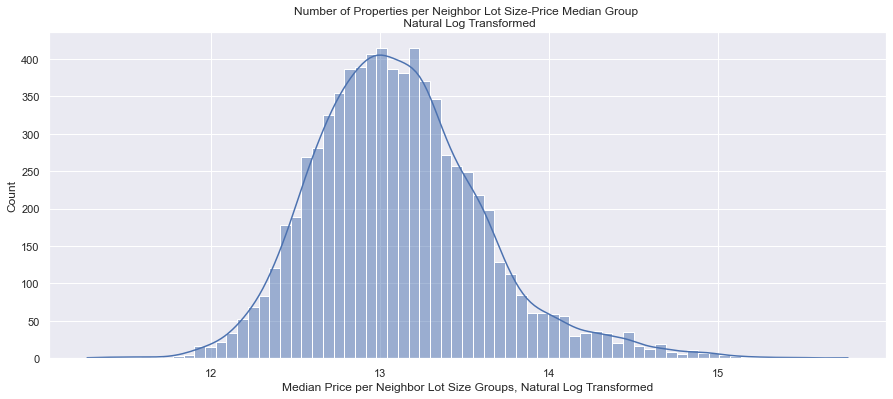

In [920]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Median Price per Neighbor Lot Size Groups, Natural Log Transformed')
ax.set_title('Number of Properties per Neighbor Lot Size-Price Median Group \n Natural Log Transformed')
sns.histplot(data=df, x=np.log(df.groupby('sqft_lot15')['price'].median()), kde=True, ax=ax);
# sns.histplot(data=df, x=df['sqft_lot15'], kde=True, log_scale=10, ax=ax);

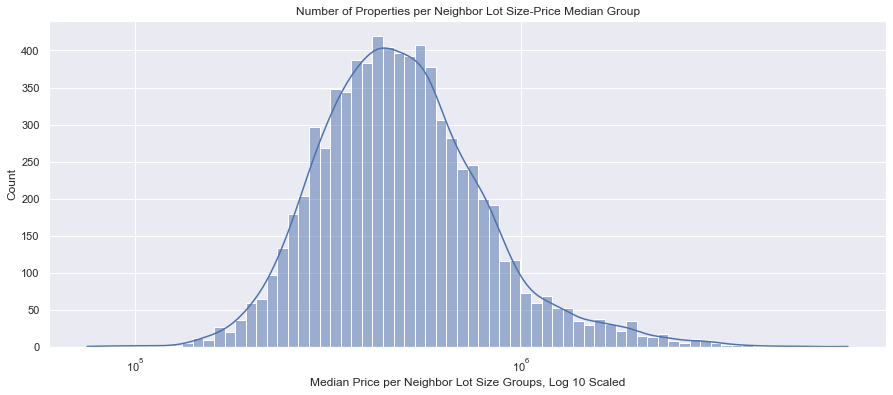

In [618]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Median Price per Neighbor Lot Size Groups, Log 10 Transformed')
ax.set_title('Number of Properties per Neighbor Lot Size-Price Median Group \n Log 10 Transformed')
sns.histplot(data=df, x=df.groupby('sqft_lot15')['price'].median(), kde=True, log_scale=10, ax=ax);
# sns.histplot(data=df, x=df['sqft_lot15'], kde=True, log_scale=10, ax=ax);

Definitions verified from 2 sources:  
https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices  
https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.htm

# yrs_since_sale

Mostly only used to engineer feature **yrs_since_ren_at_sale**, but will keep in case I consider another use for this. Will almost certainly be dropped when developing a model.

# yrs_old

Created in case I find it easier to work with than **yr_built** in certain contexts.

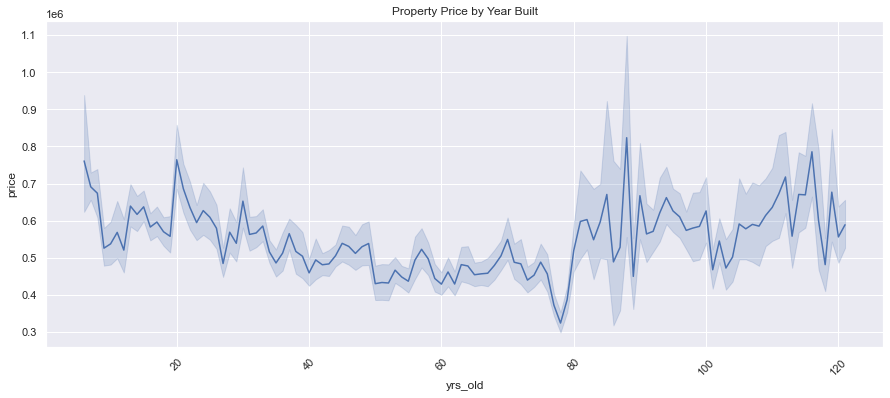

In [619]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price by Age of Property')
plt.xticks(rotation=45)
sns.lineplot(data=df, x=df.yrs_old, y=df.price, ax=ax);

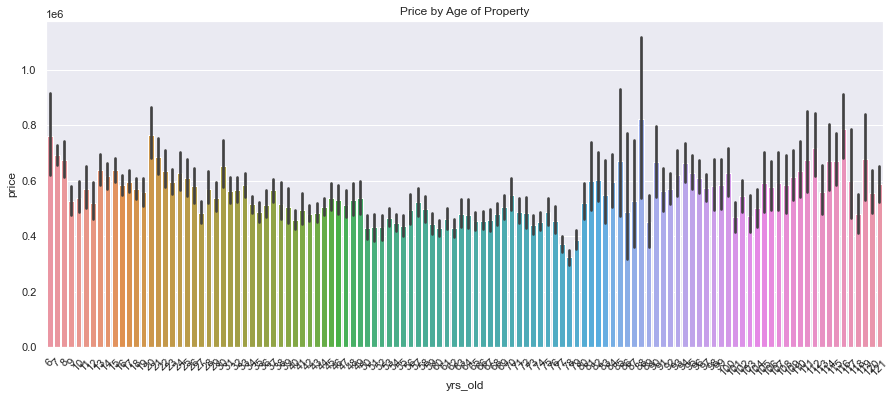

In [620]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price by Age of Property')
plt.xticks(rotation=45)
sns.barplot(data=df, x=df.yrs_old, y=df.price, ax=ax);

# yrs_since_renovation

Feature created simply for use in creating **yrs_since_ren_at_sale**, but will keep in case I consider another use for this. Will almost certainly be dropped when developing a model.

# yrs_since_ren_at_sale
- There is quite a large a range of values for price based on how recently a building was renovated at the time of sale (or built, in the case of properties that have never been renovated.
- There also seems to be a very high standard error among some of the years, which suggests that these years particularly should be managed individually.

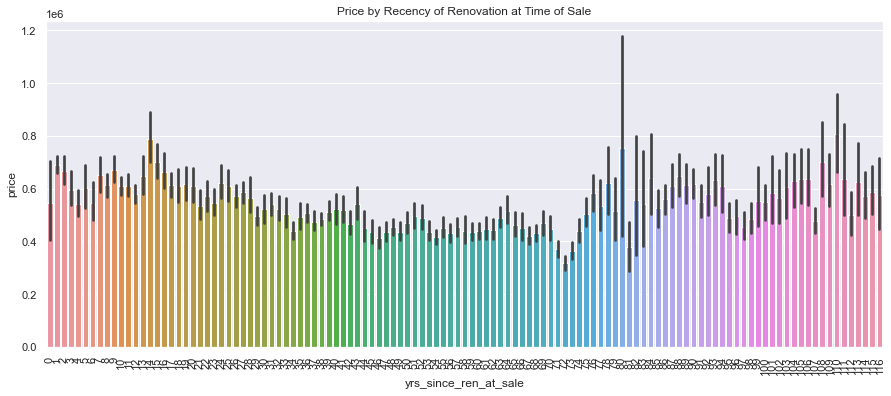

In [622]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Price by Recency of Renovation at Time of Sale')
ax.set_xlabel('Number of Years Since Restored')
plt.xticks(rotation=90)
sns.barplot(data=df, x=df.yrs_since_ren_at_sale, y=df.price, ax=ax);

# sqft_yard

Initial takeaways:
- a small handfull of properties are comparatively outliers, but I would be interested in seeing how this looks  
  
Cleaning:
- four had negative values
- set value to 0 for those using np.where statement

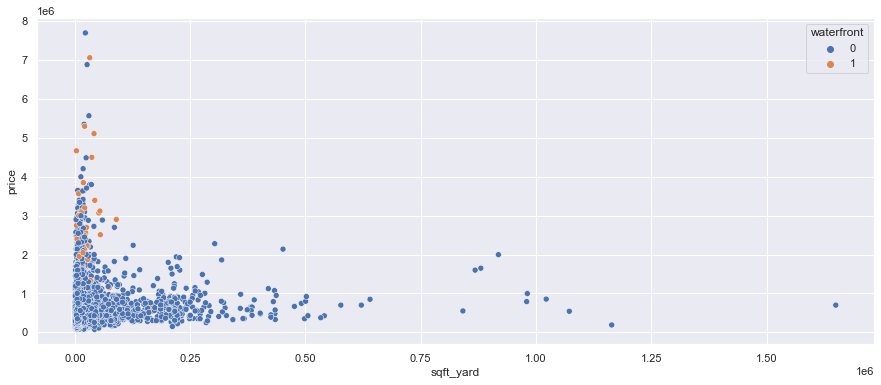

In [625]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_yard, y=df.price, hue='waterfront', ax=ax);

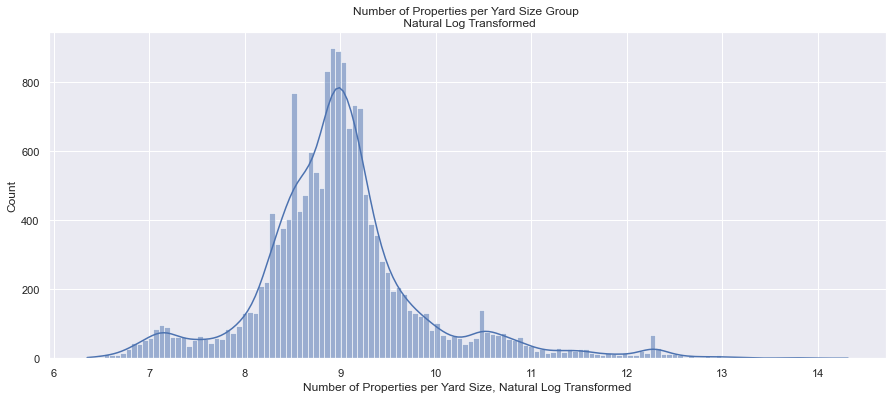

In [919]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Number of Properties per Yard Size, Natural Log Transformed')
ax.set_title('Number of Properties per Yard Size Group \n Natural Log Transformed')
sns.histplot(data=df, x=np.log(df.sqft_lot), kde=True, ax=ax);

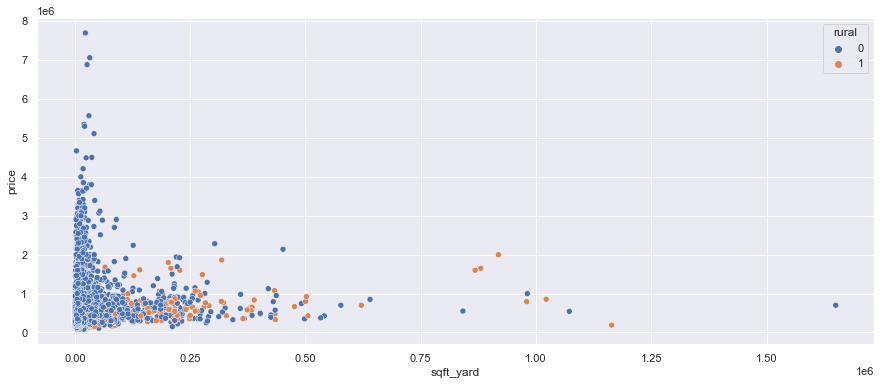

In [794]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_yard, y=df.price, hue='rural', ax=ax);

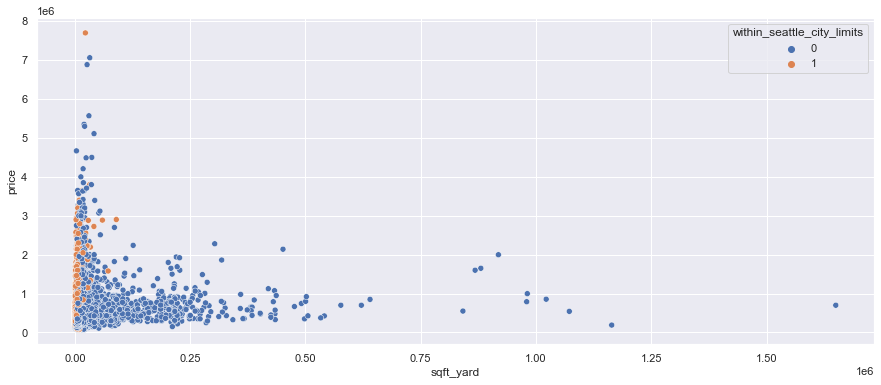

In [793]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x=df.sqft_yard, y=df.price, hue='within_seattle_city_limits', ax=ax);

# price_per_sqft_living

#### NOTE: We will NOT have price in holdout dataset, so do NOT use this feature for MODEL

Skew with histogram. Compensate with log scaling.

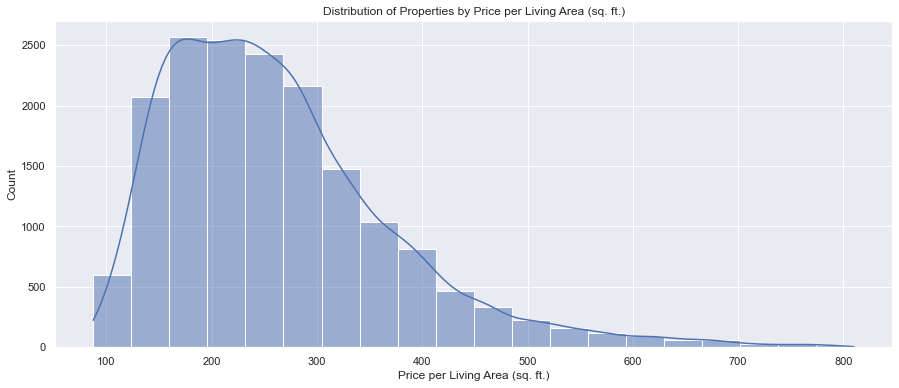

In [913]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Properties by Price per Living Area (sq. ft.)')
ax.set_xlabel('Price per Living Area (sq. ft.)')
sns.histplot(df.price_per_sqft_living, 
             bins=20,
             kde=True,
             ax=ax);

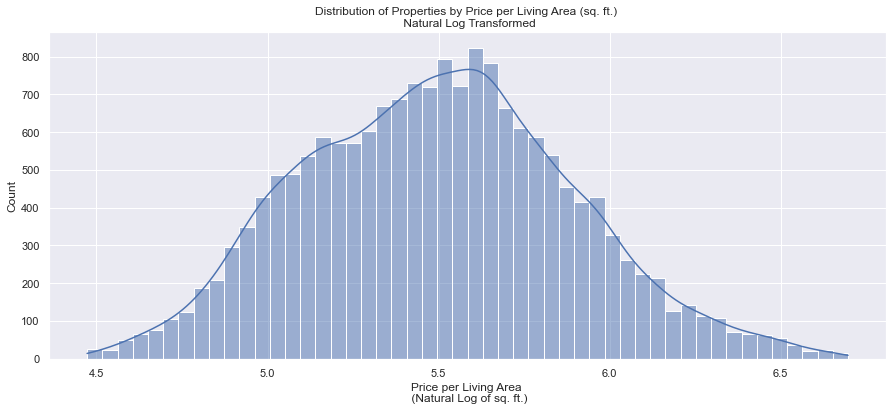

In [916]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Properties by Price per Living Area (sq. ft.) \n Natural Log Transformed')
ax.set_xlabel('Price per Living Area \n (Natural Log of sq. ft.)')
sns.histplot(np.log(df.price_per_sqft_living), # note, this appears to be messing up my xticks
             bins=50,
             kde=True,
             ax=ax);

In [809]:
rural_winter = rural[rural.sale_season_winter == 1]
rural_spring = rural[rural.sale_season_spring == 1]
rural_summer = rural[rural.sale_season_summer == 1]
rural_fall = rural[rural.sale_season_fall == 1]

suburb_winter = suburb[suburb.sale_season_winter == 1]
suburb_spring = suburb[suburb.sale_season_spring == 1]
suburb_summer = suburb[suburb.sale_season_summer == 1]
suburb_fall = suburb[suburb.sale_season_fall == 1]

city_winter = city[city.sale_season_winter == 1]
city_spring = city[city.sale_season_spring == 1]
city_summer = city[city.sale_season_summer == 1]
city_fall = city[city.sale_season_fall == 1]

#### This one's a doozy. don't think I need it.

In [818]:
# rspr_w = rural_spring[rural_spring.waterfront == 1]
# rspr = rural_spring[rural_spring.waterfront == 0]

# rsum_w = rural_summer[rural_summer.waterfront == 1]
# rsum = rural_summer[rural_summer.waterfront == 0]

# rwin_w = rural_winter[rural_winter.waterfront == 1]
# rwin = rural_winter[rural_winter.waterfront == 0]

# rfal_w = rural_fall[rural_fall.waterfront == 1]
# rfal = rural_fall[rural_fall.waterfront == 0]
  

# sspr_w = suburb_spring[suburb_spring.waterfront == 1]
# sspr = suburb_spring[suburb_spring.waterfront == 0]

# ssum_w = suburb_summer[suburb_summer.waterfront == 1]
# ssum = suburb_summer[suburb_summer.waterfront == 0]

# swin_w = suburb_winter[suburb_winter.waterfront == 1]
# swin = suburb_winter[suburb_winter.waterfront == 0]

# sfal_w = suburb_fall[suburb_fall.waterfront == 1]
# sfal = suburb_fall[suburb_fall.waterfront == 0]


# cspr_w = city_spring[city_spring.waterfront == 1]
# cspr = city_spring[city_spring.waterfront == 0]

# csum_w = city_summer[city_summer.waterfront == 1]
# csum = city_summer[city_summer.waterfront == 0]

# cwin_w = city_winter[city_winter.waterfront == 1]
# cwin = city_winter[city_winter.waterfront == 0]

# cfal_w = city_fall[city_fall.waterfront == 1]
# cfal = city_fall[city_fall.waterfront == 0]

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

Seattle City Limits Fence LAT|LONG:  
NE Corner:  
47.734178 -122.251569 # must be LESS THAN lat LESS THAN long  
SE Corner:  
47.495479 -122.251569 # must be GREATER THAN lat LESS THAN long  
SW Corner:  
47.495479 -122.438230 # must be GREATER THAN lat GREATER THAN long  
NW Corner:  
47.734178 -122.438230 # must be LESS THAN lat GREATER THAN long  
  
-122.438230 < df.long < -122.251569  
47.495479 < df.lat < 47.734178  
  
df.long < -122.251569  
df.long > -122.438230  
df.lat < 47.734178  
df.lat > 47.495479  

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# city / suburban / rural

Conditional variable that uses **within_seattle_city_limits** and **rural** engineered dummy variable features to separate rural, suburban, and city properties. 

In [803]:
rural = df[df.rural == 1]
suburb = df[(df.rural == 0) & (df.within_seattle_city_limits == 0)]
city = df[df.within_seattle_city_limits == 1]

# sale_season_x

#### Run an ANOVA test on sale_season_dummies

highest correlated to price:
- sqft_living
- grade
- sqft_above
- sqft_living15

In [172]:
df.years_old.value_counts()

6    13770
5     3520
Name: date, dtype: int64

In [157]:
df.zipcode.value_counts()

98052    474
98115    465
98103    461
98038    455
98117    437
        ... 
98102     80
98010     74
98024     65
98148     43
98039     42
Name: zipcode, Length: 70, dtype: int64